In [1]:
# Semi-stationary system:

'''
Linearized mass and momentum give rise to acoustic waves only (the particle velocity carries entropy; here we assume isothermal).
If the u-p field is equilibrated rapidly through sound waves, we discard the time-dependent terms in mass and momentum (these
are dp/dt in mass and d(rho*u)/dt in momentum).

Mass, steady:
  u0 * dp/dx + rho0 * c0^2 * du/dx = 0
Momentum, steady:
  C * mu0 * u + dp/dx + rho0 * u0 * du/dx = - C * u0 * dmu/dyc * yc
Crystal advection, unsteady:
  rho0 * dy_c/dt + rho0 * u0 * dy_c / dx = 0
'''


'\nLinearized mass and momentum give rise to acoustic waves only (the particle velocity carries entropy; here we assume isothermal).\nIf the u-p field is equilibrated rapidly through sound waves, we discard the time-dependent terms in mass and momentum (these\nare dp/dt in mass and d(rho*u)/dt in momentum).\n\nMass, steady:\n  u0 * dp/dx + rho0 * c0^2 * du/dx = 0\nMomentum, steady:\n  C * mu0 * u + dp/dx + rho0 * u0 * du/dx = - C * u0 * dmu/dyc * yc\nCrystal advection, unsteady:\n  rho0 * dy_c/dt + rho0 * u0 * dy_c / dx = 0\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Background parameters
rho0 = 2.6e3
u0 = 0.5
K = 10e9
c0 = np.sqrt(K / rho0)
C = 2 / (100.0) # Dimensional friction coefficient (2 / R^2)
mu0 = 1e9
dmudy = 1e10 # Rate of viscosity change per crystallinity

# Kernel decay length scale ~ K / (C*mu0*u0)
L = rho0 * (c0 * c0 - u0 * u0) / (C * mu0 * u0)
L

999.9999349999998

Text(0, 0.5, 'du')

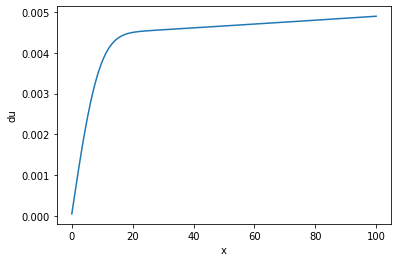

In [4]:
# Define unsteady Gaussian crystal load
forcing_wavelength = 10
k_forcing = 2 * np.pi / forcing_wavelength
psi_gaussian = lambda x, t: 0.1*np.exp(-((x - u0 * t) / forcing_wavelength) ** 2)

# Define ODE solution kernel (-> 1 as u' / u0 -> 0)
kernel = lambda x, xi: - C * u0 * u0 * dmudy * np.exp((x - xi)/L) / (rho0 * (u0*u0 - c0*c0))

# Set up view mesh
x_R = 100
x_range = np.linspace(0, x_R, 1000)
dx = x_range[1] - x_range[0]

# Two-step integration (integrand, cumulative sum over xi at fixed x, select sum of xi up to x)
integrand = psi_gaussian(x_range, 0) * kernel(x_range[...,np.newaxis], x_range)
u = dx * np.diag(np.cumsum(integrand, axis=-1))
plt.plot(x_range, u)
plt.xlabel("x")
plt.ylabel("du")

Text(0, 0.5, 'du')

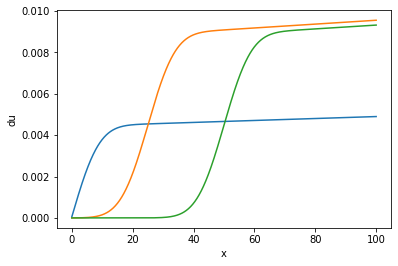

In [5]:
# t-coordinate show

u_t = lambda t: dx * np.diag(np.cumsum(
    psi_gaussian(x_range, t) * kernel(x_range[...,np.newaxis], x_range), axis=-1))
plt.plot(x_range, u_t(0))
plt.plot(x_range, u_t(50))
plt.plot(x_range, u_t(100))

plt.xlabel("x")
plt.ylabel("du")

Text(0, 0.5, 'du')

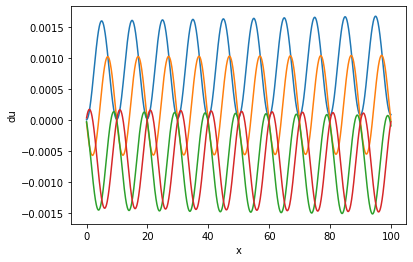

In [6]:
# t-plots for sinusoidal crystal load

# Sinusoidal crystal load
psi_sin = lambda x, t: 0.1*np.sin(k_forcing*(x - u0 * t))

# Define ODE solution kernel (-> 1 as u' / u0 -> 0)
kernel = lambda x, xi: - C * u0 * u0 * dmudy * np.exp((x - xi)/L) / (rho0 * (u0*u0 - c0*c0))

# t-coordinate psi_sinshow

u_t = lambda t: dx * np.diag(np.cumsum(
    psi_sin(x_range, t) * kernel(x_range[...,np.newaxis], x_range), axis=-1))
plt.plot(x_range, u_t(0))
plt.plot(x_range, u_t(4))
plt.plot(x_range, u_t(8))
plt.plot(x_range, u_t(12))


plt.xlabel("x")
plt.ylabel("du")

Text(0, 0.5, 'psi (crystal load change at top)')

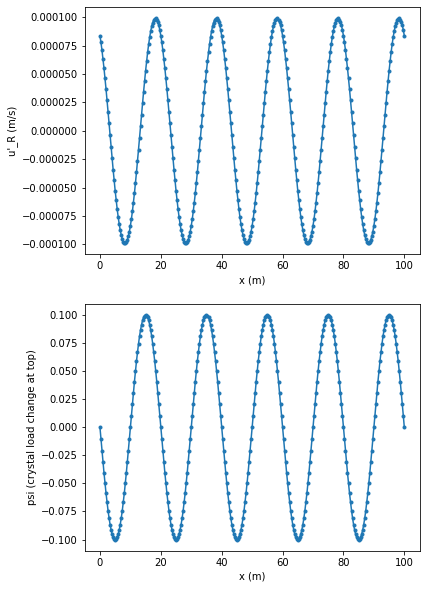

In [7]:
# Top boundary u'(t)

u_R_t = lambda t: dx * (np.sum(
    psi_sin(x_range[np.newaxis, ...], t_range[..., np.newaxis])
    * kernel(x_range[-1], x_range[np.newaxis, ...]), axis=-1))
t_range = np.linspace(0, 10 * 2*np.pi/k_forcing, 301)
plt.figure(figsize=(6,10))
plt.subplot(2,1,1)
plt.plot(t_range, u_R_t(t_range), '.-')
plt.xlabel("x (m)")
plt.ylabel("u'_R (m/s)")
plt.subplot(2,1,2)
plt.plot(t_range, psi_sin(x_range[-1], t_range), '.-')
plt.xlabel("x (m)")
plt.ylabel("psi (crystal load change at top)")

### Semi-linearization
Friction is split as coeff * u, and u is linearized

In [8]:
from scipy.special import erf
import numpy as np
import scipy.integrate


In [9]:
# Relative viscosity due to crystal content
def eta_rel(crystal_frac):
  alpha = 0.999916
  phi_crit = 0.673
  gamma = 3.98937
  delta = 16.9386
  B = 2.5
  phi_normalized = crystal_frac / phi_crit
  erf_term = erf(np.sqrt(np.pi) / (2 * alpha)
            * phi_normalized * (1 + phi_normalized**gamma))
  return 1 + phi_normalized**delta / (1 - alpha * erf_term)**(B * phi_crit)

L0 is 4626.544267352803 m


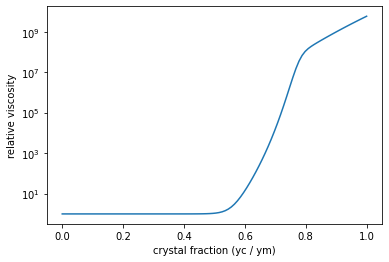

In [10]:
# Background parameters
rho0 = 2.6e3
u0 = 0.5
K0 = 10e9
mu_melt = 1e8
R0 = 10.0
c0 = np.sqrt(K0 / rho0)
M0 = u0 / c0

# Background crystal content
y0 = 0.5
# Compute background viscosity
mu0 = mu_melt * eta_rel(y0)
# Characteristic length scale of sharpening
L0 = R0*R0 / (4.0 * mu0 * u0) * K0 * (1.0 - M0*M0)

plt.semilogy(np.linspace(0,1,100), eta_rel(np.linspace(0,1,100)))
plt.xlabel("crystal fraction (yc / ym)")
plt.ylabel("relative viscosity")
print(f"L0 is {L0} m")

In [11]:
# Gaussian crystal load
forcing_wavelength = 10
psi_gaussian = lambda x, t: 0.1*np.exp(-((x - u0 * t + forcing_wavelength) / forcing_wavelength) ** 2)
# Sinusoidal crystal load
k_forcing = 2 * np.pi / forcing_wavelength
psi_sin = lambda x, t: 0.1*np.sin(k_forcing*(x - u0 * t))

# Nondimensional viscosity (mu / mu0)
mu_nondim = lambda psi, x, t: eta_rel(y0 + psi(x,t)) / eta_rel(y0)

In [12]:
# Set up view mesh
x_R = 100
Nx = 1000
x_range = np.linspace(0, x_R, Nx)
dx = x_range[1] - x_range[0]
# Show nondimensionalized viscosity
# plt.plot(x_range, mu_nondim(psi_sin, x_range, 0.0))
# plt.xlabel("x (m)")
# plt.ylabel("mu / mu0")

Text(0, 0.5, 'mu / mu0')

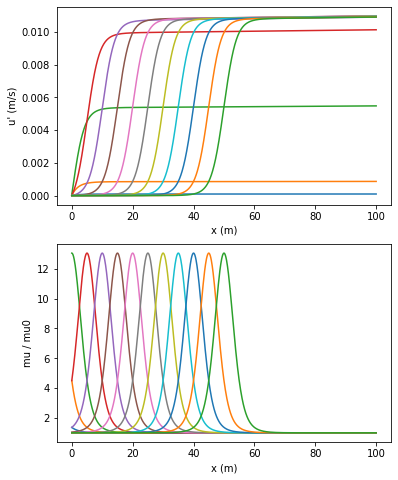

In [13]:
# Lift t_range and x_range to (x,t) space
t_range_lift = np.linspace(0,120,13)[np.newaxis, :]
x_range_lift = x_range.copy()[:, np.newaxis]

# Evaluate nondimensional viscosity with indices [x, t]
q0 = mu_nondim(psi_gaussian, x_range_lift, t_range_lift)
# Definite integrals of nondim viscosity 0 to x indexed by [x, t]
q1 = scipy.integrate.cumulative_trapezoid(q0, x_range_lift, initial=0, axis=0)
# Term exp(definite_integral(eta -> x)) indexed by [x, eta, t]
q2 = np.exp((q1[:,np.newaxis,...] - q1) / L0)
# Integrate for velocity perturbation by reducing along eta; index [x, t]
u = scipy.integrate.trapezoid(
  np.moveaxis(np.tril(np.moveaxis(q2 * (q0 - 1), (2,0,1), (0,1,2))), (0,1,2), (2,0,1)),
  x_range, axis=1) * u0 / L0
# Fix boundary condition
# Solve for pressure
p = K0 / u0 * u

plt.figure(figsize=(6,8))
plot_range = range(t_range_lift.shape[-1])
plt.subplot(2,1,1)
for i in plot_range:
  plt.plot(x_range, u[...,i])
plt.xlabel("x (m)")
plt.ylabel("u' (m/s)")
plt.subplot(2,1,2)
for i in plot_range:
  plt.plot(x_range, q0[...,i])
plt.xlabel("x (m)")
plt.ylabel("mu / mu0")

# plt.plot(K3[...,0])

Text(0.5, 1.0, 't = 30.0 s')

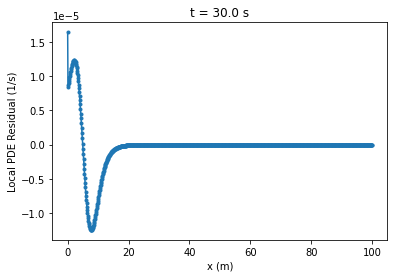

In [14]:
# PDE residual Verification
t_idx = 3
# Central approximation, with one-sided boundary closure
dudx = np.concatenate([
    (u[1:2, t_idx] - u[0:1, t_idx]) / dx,
    (u[2:, t_idx] - u[:-2, t_idx]) / (2*dx),
    (u[-1:, t_idx] - u[-2:-1, t_idx]) / dx,
])
# Compute nondimensional viscosity
load = mu_nondim(psi_gaussian, x_range_lift, t_range_lift)[...,t_idx]
# Compute PDE residual
LHS = dudx - u[...,t_idx] / L0 * load - u0 / L0 * (load - 1)
plt.plot(x_range, LHS, '.-')
plt.xlabel("x (m)")
plt.ylabel("Local PDE Residual (1/s)")
plt.title(f"t = {t_range_lift[0,t_idx]} s")

Hypothesis: the dominant effect of the crystal clot is a local drop in pressure, decreasing the density.
To maintain a constant mass flux at conduit-scale, velocity increases locally.


Text(0.5, 1.0, 't = 30.0 s')

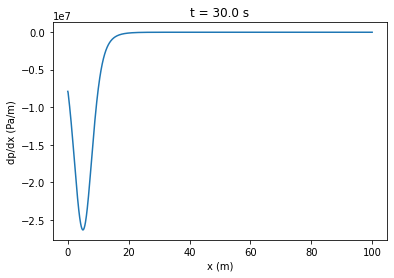

In [15]:
dpdx = - K0 / u0 * dudx
plt.plot(x_range, dpdx)
plt.xlabel("x (m)")
plt.ylabel("dp/dx (Pa/m)")

print("Hypothesis: the dominant effect of the crystal clot is a local drop in pressure, decreasing the density.")
print("To maintain a constant mass flux at conduit-scale, velocity increases locally.")
plt.title(f"t = {t_range_lift[0,t_idx]} s")


Text(0, 0.5, 'mu / mu0')

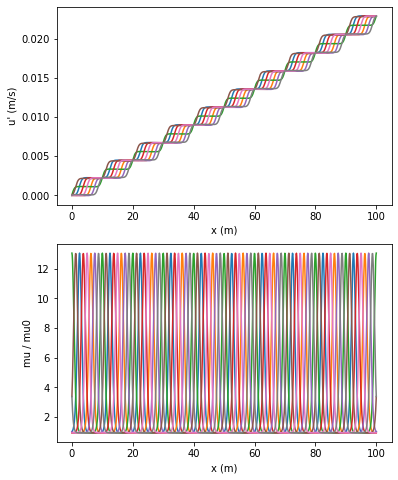

In [16]:
# Lift t_range and x_range to (x,t) space
T_forcing = (2 * np.pi) / (u0 * k_forcing)
t_range_lift = np.linspace(0,3*T_forcing,73)[np.newaxis, :-1]
x_range_lift = x_range.copy()[:, np.newaxis]

# Evaluate nondimensional viscosity with indices [x, t]
q0 = mu_nondim(psi_sin, x_range_lift, t_range_lift)
# Definite integrals of nondim viscosity 0 to x indexed by [x, t]
q1 = scipy.integrate.cumulative_trapezoid(q0, x_range_lift, initial=0, axis=0)
# Term exp(definite_integral(eta -> x)) indexed by [x, eta, t]
q2 = np.exp((q1[:,np.newaxis,...] - q1) / L0)
# Integrate for velocity perturbation by reducing along eta; index [x, t]
u = scipy.integrate.trapezoid(
  np.moveaxis(np.tril(np.moveaxis(q2 * (q0 - 1), (2,0,1), (0,1,2))), (0,1,2), (2,0,1)),
  x_range, axis=1) * u0 / L0
# Fix boundary condition
# Solve for pressure
p = K0 / u0 * u

plt.figure(figsize=(6,8))
plot_range = range(0,t_range_lift.shape[-1],9)
plt.subplot(2,1,1)
for i in plot_range:
  plt.plot(x_range, u[...,i])
plt.xlabel("x (m)")
plt.ylabel("u' (m/s)")
plt.subplot(2,1,2)
for i in plot_range:
  plt.plot(x_range, q0[...,i])
plt.xlabel("x (m)")
plt.ylabel("mu / mu0")

In [17]:
u_top = u[-1,:]
fig, ax = plt.subplots(layout='constrained')

ax.plot(t_range_lift[0,:], u_top, '.-')

plt.xlabel("t (s)")
plt.ylabel(f"u' (m/s)")
plt.title(f"At top of computed domain ({x_R} m):")
secax = ax.secondary_xaxis("top", functions=(lambda t: t/T_forcing, lambda n: n*T_forcing))
secax.set_xlabel("Crystal forcing wavelengths")
ax.grid("on")

TypeError: __init__() got an unexpected keyword argument 'layout'

Next: multiply p' by local (dp/dx)^{-1} to get linearized change in fragmentation front? What is the amplitude?

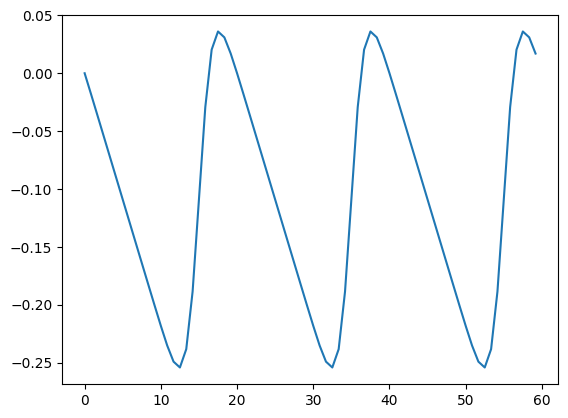

In [ ]:
# Viscous dp/dx:
dpdx0_viscous = 4 * mu0 * eta_rel(y0) * u0 / (R0 * R0)
dpdx0_g = rho0 * 9.8
plt.plot(t_range_lift[0,:], (p[-1,:] - p[-1,0])/dpdx0_viscous)

### Part 2: exsolution
The mixture of liquid magma with exsolved gas leads to a spatially dependent friction-inertia length scale L(x).
We use the steady state solver to provide a background state and take the friction model from `steady_state`.

This eventually leads to a 2x2 variable-coefficient system, which requires typical ODE solvers. If oversimplified, gives
a nonzero perturbation when subject to no forcing.

In [ ]:
import os
os.chdir(r"C:\Users\fredr\OneDrive\Documents\compressible-conduit-steady")
import steady_state


In [ ]:
# Model import
x_km_range = np.linspace(0, 15000, 100)
f = steady_state.SteadyState(x_km_range, 1e5, 100e6, input_type="p",
                             override_properties={
                               "tau_f": 1e-2,
                               "tau_d": 1e-2,
                               "yWt": 0.05,
                               "yC": 0.3,
                             }, skip_rootfinding=True)
# Water
# ywt0 = 0.04

Fragmentation criterion: VolumeFraction


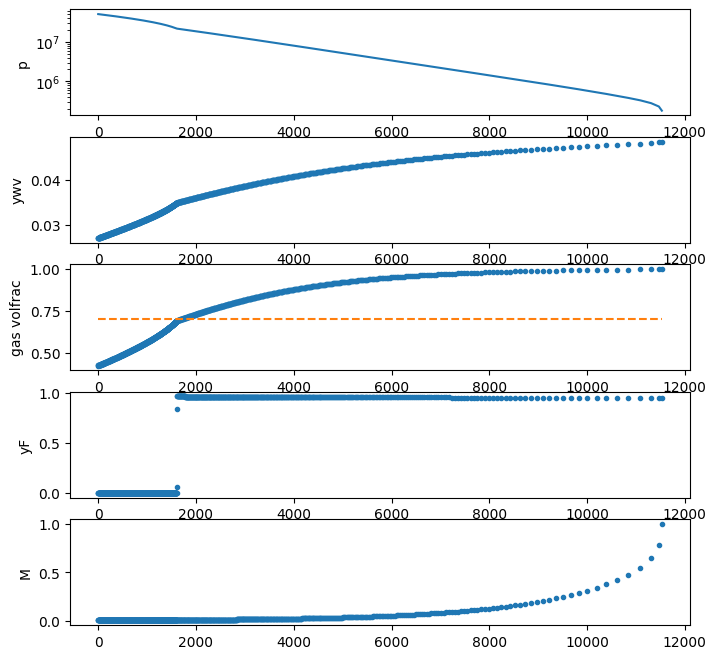

In [ ]:
# Fix j0
j0 = 1200

soln = f.solve_pcoord_system(50e6, j0)
ps_p_range = soln["range(p)"]
ps_p_vec = np.linspace(ps_p_range[1], ps_p_range[0], 1000)
ps_x = soln["x(p)"](ps_p_vec).flatten()
ps_hyy = soln["hyy(p)"](ps_p_vec)

# Extract dependent quantities
p = ps_p_vec
h, yWv, yF = ps_hyy
T = np.array(list(map(f.T_ph, p, h, yWv)))

yM = 1.0 - (f.yA + yWv)
yA = f.yA * np.ones_like(yWv)
ps_vf_g = f.mixture.vf_g(p, T, yA, yWv, yM)
c = np.array(list(map(f.mixture.sound_speed, p, T, yA, yWv, yM)))
v = f.v_mix(p, T, yWv)
ps_u = j0 * v
M = ps_u / c

plt.figure(figsize=(8,8))
plt.subplot(5,1,1)
plt.semilogy(ps_x, ps_p_vec)
plt.ylabel("p")
plt.subplot(5,1,2)
plt.plot(ps_x, ps_hyy[1,:], '.')
plt.ylabel("ywv")
plt.subplot(5,1,3)
plt.plot(ps_x, ps_vf_g, '.')
plt.plot(ps_x, f.crit_volfrac * np.ones_like(ps_x), '--')
plt.ylabel("gas volfrac")
plt.subplot(5,1,4)
plt.plot(ps_x, yF, '.')
plt.ylabel("yF")
plt.subplot(5,1,5)
# plt.plot(ps_x, v, '.')
# plt.plot(ps_x, f.mixture.waterEx.R * T / p * yWv, '.')
plt.plot(ps_x, M, '.')
plt.ylabel("M")

print(f"Fragmentation criterion: {f.fragmentation_criterion}")

Text(0, 0.5, 'L (m)')

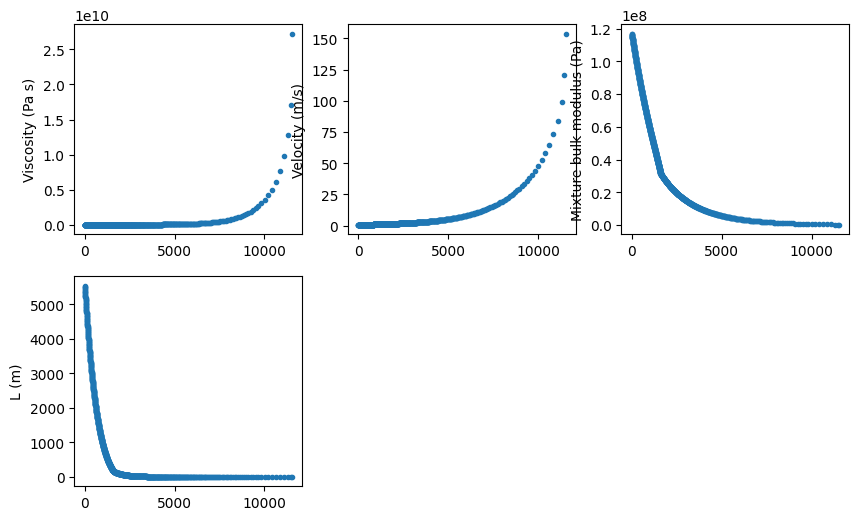

In [ ]:
'''Show background flow values'''
plt.figure(figsize=(10,6))

# Friction-intertia Length scale
conduit_radius = 10
ps_mu0 = f.F_fric_viscosity_model(T, yWv, yF)
ps_K = c * c / v
ps_L = conduit_radius * conduit_radius / (4 * ps_u) * ps_K * (1 - M*M) / ps_mu0

# Local Mach
plt.subplot(2,3,1)
plt.plot(ps_x, ps_mu0, '.')
plt.ylabel("Viscosity (Pa s)")
plt.subplot(2,3,2)
plt.plot(ps_x, ps_u, '.')
plt.ylabel("Velocity (m/s)")
plt.subplot(2,3,3)
plt.plot(ps_x, ps_K, '.')
plt.ylabel("Mixture bulk modulus (Pa)")
plt.subplot(2,3,4)
plt.plot(ps_x, ps_L, '.')
plt.ylabel("L (m)")


In [ ]:
# WIP Copy (if water dissolved concentration changes)
def steady_viscosity_model(T, yWv, yL, yWt, yA, yC):
  ''' Self-independent version of viscosity model '''
  yWd = yWt - yWv
  yM = 1.0 - (yWv + yA)

  mfWd = yWd / yL # mass concentration of dissolved water
  mfWd = np.where(mfWd <= 0.0, 1e-8, mfWd)
  log_mfWd = np.log(mfWd*100)
  log10_vis = -3.545 + 0.833 * log_mfWd
  log10_vis += (9601 - 2368 * log_mfWd) / (T - 195.7 - 32.25 * log_mfWd)
  # Prevent overflowing float
  log10_vis = np.where(log10_vis > 300, 300, log10_vis)
  meltVisc = 10**log10_vis
  # Calculate relative viscosity due to crystals (Costa 2005).
  alpha = 0.999916
  phi_cr = 0.673
  gamma = 3.98937
  delta = 16.9386
  B = 2.5
  # Compute volume fraction of crystal at equal phasic densities
  # Using crystal volume per (melt + crystal + dissolved water) volume
  phi_ratio = np.clip((yC / yM) / phi_cr, 0.0, None)
  erf_term = erf(
    np.sqrt(np.pi) / (2 * alpha) * phi_ratio * (1 + phi_ratio**gamma))
  crysVisc = (1 + phi_ratio**delta) * ((1 - alpha * erf_term)**(-B * phi_cr))

  viscosity = meltVisc * crysVisc
  return viscosity

In [ ]:
# Set up view mesh
x_R = 1500
Nx = 500
x_range = np.linspace(0, x_R, Nx)
dx = x_range[1] - x_range[0]

# Interpolate u0, L
interp_u0 = np.interp(x_range, ps_x, ps_u)
interp_L = np.interp(x_range, ps_x, ps_L)
interp_u0.shape, interp_L.shape

# # Check interp
# plt.plot(ps_x, ps_L)
# plt.plot(x_range, interp_L, '.')

((500,), (500,))

Text(0, 0.5, 'mu / mu0')

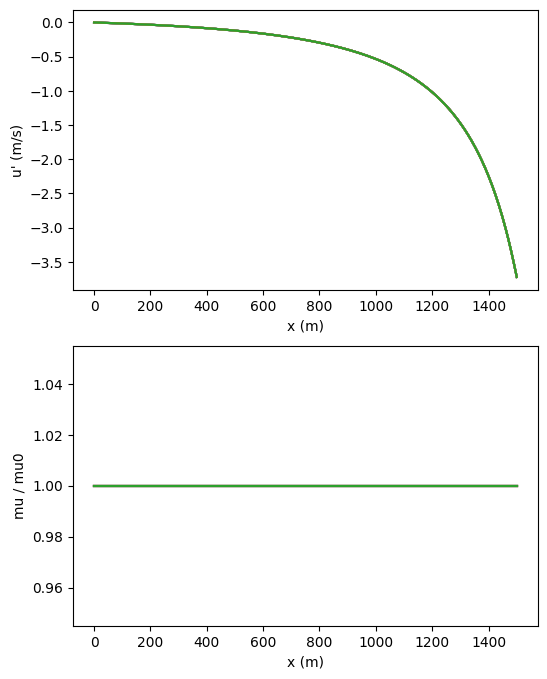

In [ ]:
# Gaussian crystal load
forcing_wavelength = 10
psi_amplitude = 0.00
psi_gaussian = lambda x, t: psi_amplitude * np.exp(-((x - u0 * t + forcing_wavelength) / forcing_wavelength) ** 2) # TODO: advection of psi by integrating u0 field
# Sinusoidal crystal load
k_forcing = 2 * np.pi / forcing_wavelength
psi_sin = lambda x, t: psi_amplitude * np.sin(k_forcing*(x - u0 * t))
y0 = 0.4

# Relative viscosity due to crystal content
def eta_rel(crystal_frac):
  ''' Viscosity enhancement due to crystal content
  crystal_frac: crystals per melt yC/yM. '''
  alpha = 0.999916
  phi_crit = 0.673
  gamma = 3.98937
  delta = 16.9386
  B = 2.5
  phi_normalized = crystal_frac / phi_crit
  erf_term = erf(np.sqrt(np.pi) / (2 * alpha)
            * phi_normalized * (1 + phi_normalized**gamma))
  return 1 + phi_normalized**delta / (1 - alpha * erf_term)**(B * phi_crit)

# Nondimensional viscosity (mu / mu0) using yM approx yL >> yWd, yC approx yC / yM
mu_nondim = lambda psi, x, t: eta_rel(y0 + psi(x,t)) / eta_rel(y0)

# Show nondimensionalized viscosity
# plt.plot(x_range, mu_nondim(psi_sin, x_range, 0.0))
# plt.xlabel("x (m)")
# plt.ylabel("mu / mu0")

# Lift t_range and x_range to (x,t) space
t_range_lift = np.linspace(0,120,13)[np.newaxis, :]
x_range_lift = x_range.copy()[:, np.newaxis]

# Evaluate nondimensional viscosity with indices [x, t]
q0 = mu_nondim(psi_gaussian, x_range_lift, t_range_lift) / interp_L[:, np.newaxis]
# Definite integrals of nondim viscosity 0 to x indexed by [x, t]
q1 = scipy.integrate.cumulative_trapezoid(q0, x_range_lift, initial=0, axis=0)
# Term exp(definite_integral(eta -> x)) indexed by [x, eta, t]
q2 = np.exp((q1[:,np.newaxis,...] - q1))
# Integrate for velocity perturbation by reducing along eta; index [x, t]
u = scipy.integrate.trapezoid(
  np.moveaxis(np.tril(np.moveaxis(q2 * (q0 - 1), (2,0,1), (0,1,2))), (0,1,2), (2,0,1)) * interp_u0[:, np.newaxis] / interp_L[:, np.newaxis],
  x_range, axis=1)
# Fix boundary condition

# Solve for pressure-- use integration by parts
# p = K0 / u0 * u

plt.figure(figsize=(6,8))
plot_range = range(t_range_lift.shape[-1])
plt.subplot(2,1,1)
for i in plot_range:
  plt.plot(x_range, u[...,i])
plt.xlabel("x (m)")
plt.ylabel("u' (m/s)")
plt.subplot(2,1,2)
for i in plot_range:
  plt.plot(x_range, q0[...,i] * interp_L)
plt.xlabel("x (m)")
plt.ylabel("mu / mu0")

# plt.plot(K3[...,0])

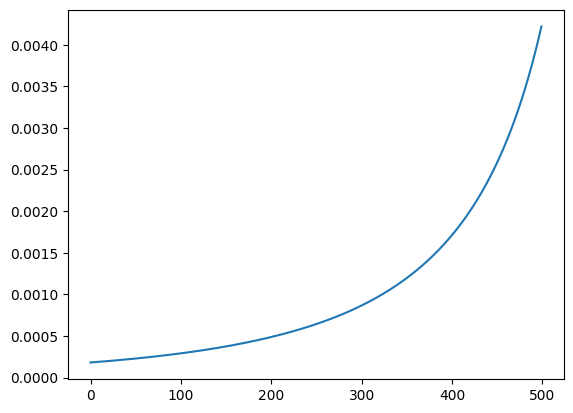

In [ ]:
plt.plot(q0[:,0])

### Use steady-state solver with constant-velocity advection of crystal 

In [ ]:
'''
The linearized mass-momentum system becomes
d  [p'     ]                         [ 0                  2           ] [p'     ]                                      [1         ]
__ [rho0 u'] + (du0/dx) / (1 - M0^2) [ (1 - M0^2)/c0^2)  -2 M0^2 / u0 ] [rho0 u'] = 1 / (1 - M0^2) * (diff friction) * [-M0^2 / u0]
dx
which is a system with variable coefficients. Exact solution is not generally possible unless the matrix evaluated at arbitrary x1, x2 commutes.
Otherwise, approximation is possible through a Magnus expansion or a numerical solution.
'''

forcing_wavelength = 100
forcing_timescale = 100
u0 = 0.75
# As a source time function
psi_gaussian_t = lambda t: 0.1 * np.exp(-(t / forcing_timescale) ** 2)
# Constant velocity advection solution
psi_gaussian = lambda x, t: 0.1*np.exp(-((x - u0 * t + forcing_wavelength) / forcing_wavelength) ** 2)


yC_fn = lambda x: 0.3 * np.ones_like(x) + psi_gaussian(x, forcing_wavelength / u0 * 10)
yWt_fn = lambda x: 0.05 * np.ones_like(x)

soln_yC = f.solve_ssIVP_yC_profile(50e6, j0, yC_fn,
                             yWt_fn, dense_output=False)
print("Solver status:")
print("==============")

print(soln_yC[2][0])

Solver status:
  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  1.862e-01 ...  1.158e+04  1.158e+04]
        y: [[ 5.000e+07  5.000e+07 ...  1.825e+05  1.825e+05]
            [ 3.217e+06  3.217e+06 ...  3.083e+06  3.083e+06]
            [ 2.702e-02  2.702e-02 ...  4.859e-02  4.859e-02]
            [ 0.000e+00  0.000e+00 ...  9.514e-01  9.514e-01]]
      sol: None
 t_events: [array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
 y_events: [array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
     nfev: 9234
     njev: 56
      nlu: 2598


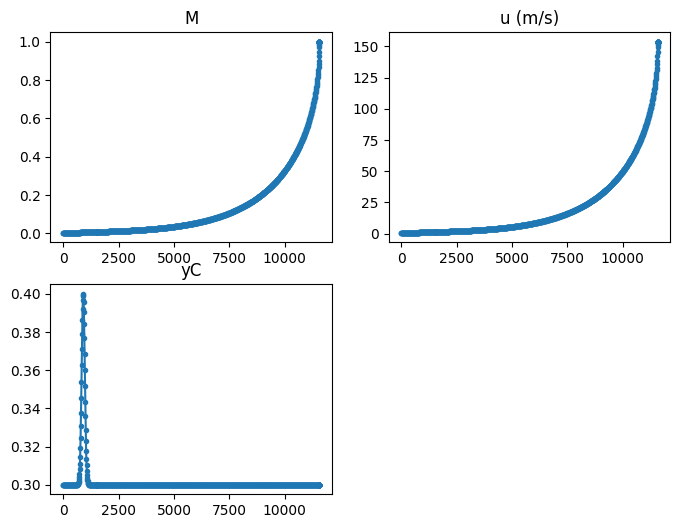

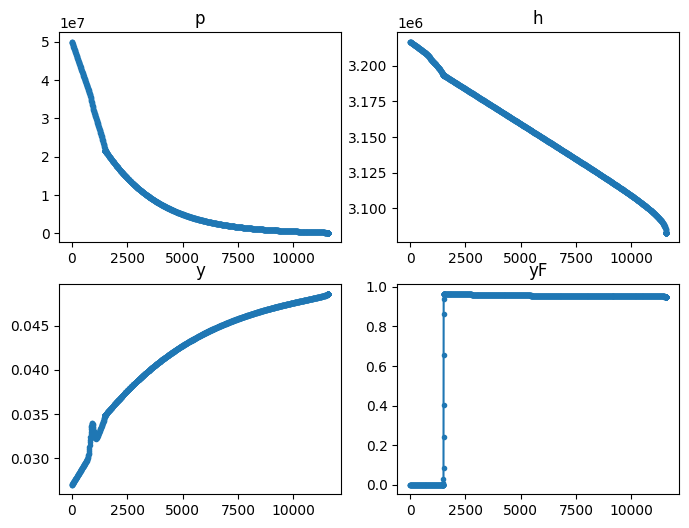

In [ ]:
# Extract dependent quantities
p, h, yWv, yF = soln_yC[1]
T = np.array(list(map(f.T_ph, p, h, yWv)))

yM = 1.0 - (f.yA + yWv)
yA = f.yA * np.ones_like(yWv)
ps_vf_g = f.mixture.vf_g(p, T, yA, yWv, yM)
c = np.array(list(map(f.mixture.sound_speed, p, T, yA, yWv, yM)))

v = f.v_mix(p, T, yWv)
u = j0 * v
M = u / c

x = soln_yC[0]

plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.plot(x, M, '.-')
plt.title("M")
plt.subplot(2,2,2)
plt.plot(x, u, '.-')
plt.title("u (m/s)")
plt.subplot(2,2,3)
plt.plot(x, yC_fn(x), '.-')
plt.title("yC")

plt.figure(figsize=(8,6))
labels = ["p", "h", "y", "yF"]
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.plot(x, soln_yC[1][i,:], '.-')
  plt.title(labels[i])



### With velocity field integration

In [ ]:
x_km_range = np.linspace(0, 15000, 100)
f = steady_state.SteadyState(x_km_range, 1e5, 100e6, input_type="p",
                             override_properties={
                               "tau_f": 1e0, # 1e-2,
                               "tau_d": 1e0, # 1e-2,
                              #  "yWt": 0.05,
                               "yC": 0.4,
                               "rho0_magma": 2.6e3,
                             }, skip_rootfinding=True)

Text(0, 0.5, 'source value')

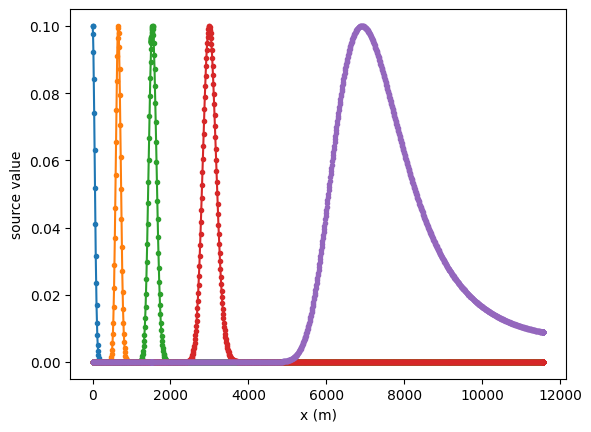

In [ ]:
# Advection map
os.chdir(r"C:\Users\fredr\OneDrive\Documents\compressible-conduit-steady")
import advection_map

# Apply advection map by integrating slowness
for delta_t in np.linspace(0,3250,5):
  # Evalate sources at nodes x
  sources_x = advection_map.advection_map(x, x, u, (lambda t: psi_gaussian_t(t + delta_t),))
  # Extract
  gaussian_source = sources_x[0]
  plt.plot(x, gaussian_source, '.-')
plt.xlabel("x (m)")
plt.ylabel("source value")

In [ ]:
f.rho0_magma

2600.0

In [ ]:
''' Compute base flow '''
yC_background_fn = lambda x: 0.4 * np.ones_like(x)

soln_background = f.solve_ssIVP_yC_profile(40e6, j0, yC_background_fn,
                                   yWt_fn, dense_output=False)


In [ ]:
''' Set forcing '''
forcing_timescale = 4.0
t_delay = 20.0
# As a source time function
psi_gaussian_t = lambda t: 0.1 * np.exp(-((t - t_delay) / forcing_timescale) ** 2)
# Apply advection map
x_background = soln_background[0]
p_background, h_background, yWv_background, yF_background = soln_background[1]
T_background = np.array(list(map(f.T_ph, p_background, h_background, yWv_background)))
yM_background = 1.0 - (f.yA + yWv_background)
yA_background = f.yA * np.ones_like(yWv_background)
vf_g_background = f.mixture.vf_g(p_background, T_background, yA_background, yWv_background, yM_background)
c_background = np.array(list(map(f.mixture.sound_speed,
                                 p_background, T_background, yA_background,
                                 yWv_background, yM_background)))
v_background = f.v_mix(p_background, T_background, yWv_background)
u_background = j0 * v_background
M_background = u_background / c_background

# Background velocity as a function of x and macroscopic t
psi_mapped_xt = lambda x, t_macro: advection_map.advection_map(x, x_background, u_background, (lambda t: psi_gaussian_t(t + t_macro),))
# Assemble spatial distribution of yC 
yC_fn = lambda x, t_macro: yC_background_fn(x) + psi_mapped_xt(x, t_macro)

# Assemble spatial distribution of yWt
yWt_fn = lambda x: 0.03 * (1 - 0.4) / (1 + 0.03) * np.ones_like(x)

# Assemble solver for perturbed crystal profile at time t
solve_perturbed = lambda t_macro: f.solve_ssIVP_yC_profile(50e6, j0, lambda x: yC_fn(x, t_macro),
                             yWt_fn, dense_output=False)

# print("Solver status:")
# print("==============")
# print(soln_yC[2][0])

In [ ]:
t_macro_range = np.linspace(0,3250,81)
QSS_solver_outputs = [solve_perturbed(t) for t in t_macro_range]

C:\Users\fredr\OneDrive\Documents\compressible-conduit-steady\material_properties.py:168: RuntimeWarning: invalid value encountered in log
  return self.K/self.rho0 * (u - np.log(1 + u))


In [ ]:
QSS_solver_outputs[0][2]

(  message: Required step size is less than spacing between numbers.
   success: False
    status: -1
         t: [ 0.000e+00  4.324e-01 ...  3.961e+03  3.961e+03]
         y: [[ 5.000e+07  4.999e+07 ...  1.075e+05  1.075e+05]
             [ 3.239e+06  3.239e+06 ...  3.186e+06  3.186e+06]
             [ 1.000e-05  1.000e-05 ...  1.636e-02  1.636e-02]
             [ 0.000e+00  0.000e+00 ...  9.837e-01  9.837e-01]]
       sol: None
  t_events: [array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
  y_events: [array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
      nfev: 3661
      njev: 34
       nlu: 1006,
 array([-1.00254581e+00,  1.72762773e-07,  9.02845770e+01,  9.02845770e+01]))

Text(0, 0.5, 'y exsolved')

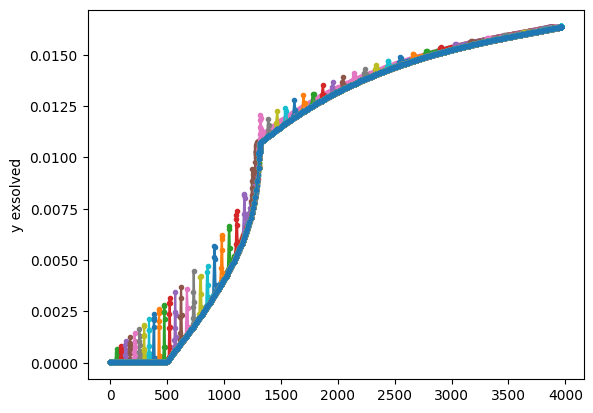

In [ ]:
for t_idx in range(t_macro_range.size):
  plt.plot(QSS_solver_outputs[t_idx][0], QSS_solver_outputs[t_idx][1][2,:], '.-')
plt.ylabel("y exsolved")

In [ ]:
''' Post process macro-time solutions '''

# Allocate heterogeneous-sized output arrays
x_macro_range = np.array([None] * t_macro_range.size, dtype=object)
vf_macro_range = np.array([None] * t_macro_range.size, dtype=object)
hf_macro_range = np.array([0] * t_macro_range.size, dtype=float)

for t_idx in range(t_macro_range.size):
  x_macro_range[t_idx] = QSS_solver_outputs[t_idx][0]
  _p, _h, _yWv, _yF = QSS_solver_outputs[t_idx][1]
  _yM = 1.0 - (f.yA + _yWv)
  _yA = f.yA * np.ones_like(_yWv)
  vf_macro_range[t_idx] = f.mixture.vf_g(_p,
                                         np.array(list(map(f.T_ph, _p, _h, _yWv))),
                                         _yA, _yWv, _yM)
  
  hf_macro_range[t_idx] = np.interp(f.crit_volfrac, vf_macro_range[t_idx], x_macro_range[t_idx])
  
  # c_background = np.array(list(map(f.mixture.sound_speed,
  #                               p_background, T_background, yA_background,
  #                               yWv_background, yM_background)))
  # v_background = f.v_mix(p_background, T_background, yWv_background)
  # u_background = j0 * v_background
  # M_background = u_background / c_background

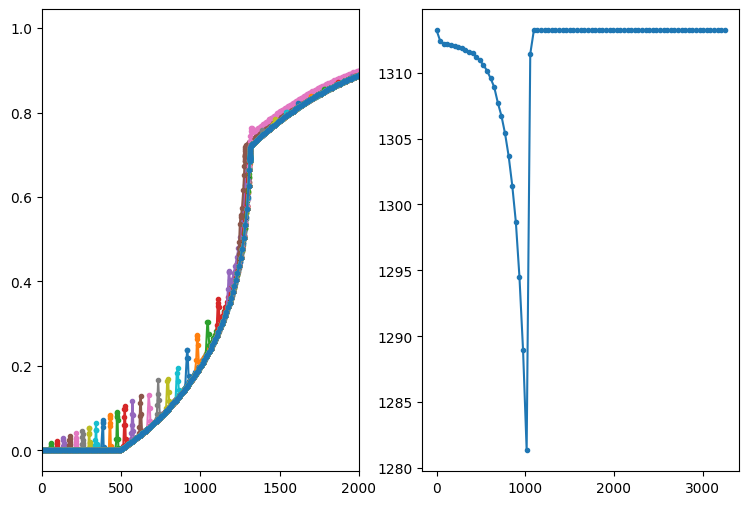

In [ ]:
''' Plot fragmentation front stuff '''
plt.figure(figsize=(9,6))

plt.subplot(1,2,1)
for t_idx in range(t_macro_range.size):
  plt.plot(x_macro_range[t_idx], vf_macro_range[t_idx], '.-')
plt.xlim(0, 2000)

plt.subplot(1,2,2)
plt.plot(t_macro_range, hf_macro_range, '.-')


Text(0.5, 1.0, 'Dots show range of fragmentation heights')

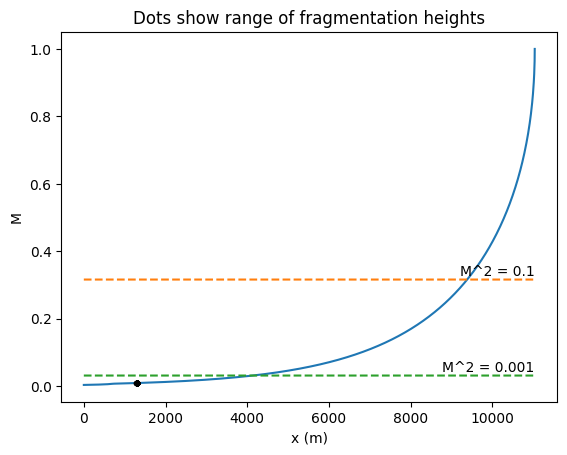

In [ ]:
plt.plot(x_background, M_background)
plt.xlabel("x (m)")
plt.ylabel("M")
# Guideline M^2 = 0.1
plt.plot(x_background, np.sqrt(0.1)*np.ones_like(x_background), '--')
plt.text(x_background[-1], .01 + np.sqrt(0.1), "M^2 = 0.1", horizontalalignment="right")
# Guideline M^2 = 0.01
plt.plot(x_background, np.sqrt(0.001)*np.ones_like(x_background), '--')
plt.text(x_background[-1], .01 + np.sqrt(0.001), "M^2 = 0.001", horizontalalignment="right")

# plt.legend(["M", "M^2 = 0.1"])
plt.plot(hf_macro_range, np.interp(hf_macro_range, x_background, M_background), 'k.')
plt.title("Dots show range of fragmentation heights")

### Splitting scheme: solve transport with local velocity field, coupled with quasi-steady mass + momentum

In [ ]:
''' Compute base flow '''
yC_background_fn = lambda x: 0.4 * np.ones_like(x)

soln_background = f.solve_ssIVP_yC_profile(40e6, j0, yC_background_fn,
                                   yWt_fn, dense_output=False)

In [ ]:
''' Set forcing '''
forcing_timescale = 4.0
t_delay = 20.0
# As a source time function
psi_gaussian_t = lambda t: 0.1 * np.exp(-((t - t_delay) / forcing_timescale) ** 2)
# Apply advection map
x_background = soln_background[0]
p_background, h_background, yWv_background, yF_background = soln_background[1]
T_background = np.array(list(map(f.T_ph, p_background, h_background, yWv_background)))
yM_background = 1.0 - (f.yA + yWv_background)
yA_background = f.yA * np.ones_like(yWv_background)
vf_g_background = f.mixture.vf_g(p_background, T_background, yA_background, yWv_background, yM_background)
c_background = np.array(list(map(f.mixture.sound_speed,
                                 p_background, T_background, yA_background,
                                 yWv_background, yM_background)))
v_background = f.v_mix(p_background, T_background, yWv_background)
u_background = j0 * v_background
M_background = u_background / c_background

# Background velocity as a function of x and macroscopic t
psi_mapped_xt = lambda x, t_macro: advection_map.advection_map(x, x_background, u_background, (lambda t: psi_gaussian_t(t + t_macro),))
# Assemble spatial distribution of yC 
yC_fn = lambda x, t_macro: yC_background_fn(x) + psi_mapped_xt(x, t_macro)

# Assemble spatial distribution of yWt
yWt_fn = lambda x: 0.03 * (1 - 0.4) / (1 + 0.03) * np.ones_like(x)

# Assemble solver for perturbed crystal profile at time t
solve_perturbed = lambda t_macro: f.solve_ssIVP_yC_profile(50e6, j0, lambda x: yC_fn(x, t_macro),
                             yWt_fn, dense_output=False)

# print("Solver status:")
# print("==============")
# print(soln_yC[2][0])

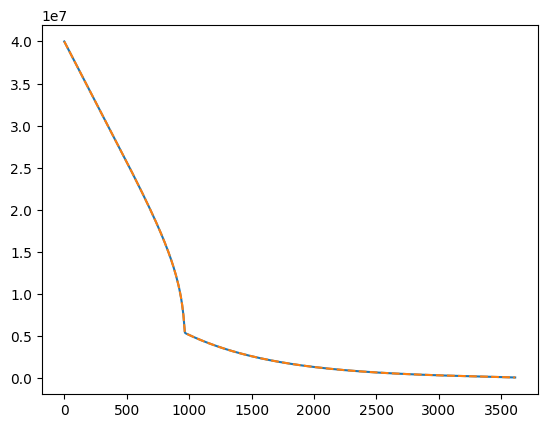

In [ ]:
x, p, h, yWv, yF, T, yM, yA, vf_g, c, v, u, M = (
    x_background,
    p_background,
    h_background,
    yWv_background,
    yF_background,
    T_background,
    yM_background,
    yA_background,
    vf_g_background,
    c_background,
    v_background,
    u_background,
    M_background,
)
rho = 1/v

plt.plot(x, p)


rho_m0 = f.mixture.magma.rho0
p_m0 = f.mixture.magma.p_ref
K = f.mixture.magma.K # 10e9
R_a = f.mixture.air.R
R_wv = f.mixture.waterEx.R # 8.314e3/18.02
ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
# plt.plot(x, ptilde)
_Z = 0.5 * (ptilde + np.sqrt(ptilde**2 + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
plt.plot(x, _Z, '--')


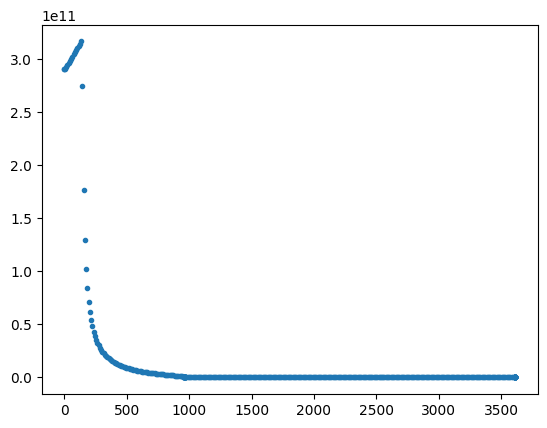

In [ ]:
# plt.plot(x, p / (2 * p - ptilde))

squared_sound_speed_isothermal = (yM * p * K / p_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
# plt.plot(x, np.sqrt(squared_sound_speed_isothermal), '.-')

dp_dyw = (-p * (K * rho / rho_m0) + (p + K - p_m0) * rho * R_wv * T) / (2*p - ptilde)
plt.plot(x, dp_dyw, '.')

### Total steady state, isothermal, specified mass flux
This was a work-in-progress code section, but did not have density dependent on t (due to composition change).

In [ ]:
f.conduit_radius

50

C:\Users\fredr\AppData\Local\Temp\ipykernel_16060\339131476.py:42: RuntimeWarning: invalid value encountered in scalar divide
  vf_g = rho * yWv / rhoWv
C:\Users\fredr\AppData\Local\Temp\ipykernel_16060\339131476.py:49: RuntimeWarning: invalid value encountered in scalar power
  yHat = np.clip(solubility_k * p ** solubility_n * yL, 0, yWt)


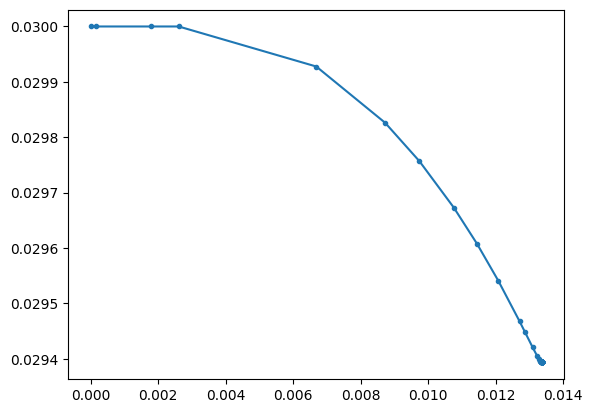

In [ ]:
T0 = 1000 + 273.15
j0 = 400

# yWt_fn = lambda x: 0.03 * np.ones_like(x)
# yC_fn = lambda x: 0.4 * np.ones_like(x)
# yF_fn = lambda x: 0.0 * np.ones_like(x)
# yWv_fn = lambda x: np.interp(x, x_background, yWv_background)

# Left side difference + extend approximation
# dyWv_dx = np.diff(yWv) / np.diff(x)
# dyWv_dx = np.array([*dyWv_dx, dyWv_dx[-1]])

# Parameters
tau_d = 1.0
tau_f = 1.0
vf_g_crit = 0.8
solubility_n = f.solubility_n
solubility_k = f.solubility_k

def RHS(t, q):
  # Unpack ODE vector
  q = np.asarray(q)
  rho = q[0,...]
  yWv = q[1,...]
  yWt = q[2,...]
  yC  = q[3,...]
  yF  = q[4,...]

  # Compute dependent quantites
  yA = 0.0
  yM = 1.0 - yWv
  T = T0
  yWd = yWt - yWv
  yL = (yM - (yC + yWd))
  # Compute steady-state velocity
  u = j0 / rho
  # Compute pressure
  ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
  p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
  # Compute gas volume fraction
  rhoWv = p / (R_wv * T)
  vf_g = rho * yWv / rhoWv
  # Compute mixture isothermal sound speed, squared
  cT2 = (yM * p * K / rho_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
  # Compute partial of pressure w.r.t. water mass fraction
  dp_dyw = (-p * (K * rho / rho_m0) + (p + K - p_m0) * rho * R_wv * T) / (2*p - ptilde)
 
  # Compute solubility based on pure silicate melt mass fraction
  yHat = np.clip(solubility_k * p ** solubility_n * yL, 0, yWt)
  # Compute total steady state advection RHS
  dyWv_dx = (yWd - yHat) / (tau_d * u)
  dyWt_dx = np.zeros_like(p)
  dyC_dx  = np.zeros_like(p)
  dyF_dx  = (yM - yF) / (tau_f * u) * np.asarray(vf_g - vf_g_crit > 0.0).astype(float)
  # Compute steady-state momentum RHS
  _LHS_factor = (cT2 - u*u)
  _RHS_factor = -dp_dyw * dyWv_dx - rho * 9.8 + f.F_fric(p, T, yWt, yF, rho, u, yWt, yC)
  drho_dx = _RHS_factor / _LHS_factor

  # Assemble RHS vector with shape (5,:)
  return np.stack([drho_dx,
                   dyWv_dx,
                   dyWt_dx,
                   dyC_dx,
                   dyF_dx,
                   ], axis=0)

class EventIsothermalChoked():
  def __init__(self):
    self.terminal = True
    self.direction = 1.0
  def __call__(self, t, q):
    # Unpack ODE vector
    q = np.asarray(q)
    rho = q[0,...]
    yWv = q[1,...]
    yWt = q[2,...]
    yC  = q[3,...]
    yF  = q[4,...]
    # Compute dependent quantites
    yA = 0.0
    yM = 1.0 - yWv
    T = T0
    # Compute steady-state velocity
    u = j0 / rho
    # Compute pressure
    ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
    p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
    # Compute mixture isothermal sound speed, squared
    cT2 = (yM * p * K / rho_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
    return u*u/cT2

# Inlet
p0 = 100e6
yWt0 = 0.03
yC0 = 0.3
yF0 = 0.0
# Compute phase mass fractions from solubility
xi = solubility_k * p0 ** solubility_n
yWd0 = np.clip(xi *(1.0 - (yWt0 + yC0)), 0, yWt0)
yWv0 = yWt0 - yWd0
yM0 = 1.0 - yWv0
# Compute densities
rhoM0 = rho_m0 * (1 + (p0 - p_m0) / K)
vM0 = 1.0 / rhoM0
vWv0 = R_wv * T0 / p0
v0 = yM0 * vM0 + yWv0 * vWv0
rho0 = 1.0 / v0
# Assemble initial condition
q0 = np.array([rho0, yWv0, yWt0, yC0, yF0])


q0, RHS(0.0, q0)

soln = scipy.integrate.solve_ivp(RHS,
        (0, 1),
        q0,
        method="Radau",
        dense_output=False, max_step=1.0,
        events=[EventIsothermalChoked(),])
# Output solution
soln_state = soln.y
# (rho, yWv, yWt, yC, yF)
plt.plot(soln.t, soln.y[2,:] - soln.y[1,:], '.-')

# _p = pressure(soln.y)
# plt.figure()
# plt.plot(soln.t, _p)

# yL0 = yM0 - (yC0 + yWd0)
# yL0 * solubility_k * p0 ** solubility_n, yWd0, yL0, 1 - (yC0 + yWt0)

In [ ]:
# p state-gradient test

def pressure(q):
  q = np.asarray(q)
  rho = q[0,...]
  yWv = q[1,...]

  # Compute dependent quantites
  yA = 0.0
  yM = 1.0 - yWv
  T = T0
  # Compute steady-state velocity
  # Compute pressure
  ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
  p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
  return p

def pressure_sgrad(q):
  q = np.asarray(q)
  rho = q[0,...]
  yWv = q[1,...]
  yWt = q[2,...]
  yC  = q[3,...]
  yF  = q[4,...]

  # Compute dependent quantites
  yA = 0.0
  yM = 1.0 - yWv
  T = T0
  yWd = yWt - yWv
  # Compute steady-state velocity
  u = j0 / rho
  # Compute pressure
  ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
  p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
  # Compute gas volume fraction
  rhoWv = p / (R_wv * T)
  vf_g = rho * yWv / rhoWv
  # Compute mixture isothermal sound speed, squared
  cT2 = (yM * p * K / rho_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
  # Compute partial of pressure w.r.t. water mass fraction
  dp_dyw = (-p * (K * rho / rho_m0) + (p + K - p_m0) * rho * R_wv * T) / (2*p - ptilde)

  return dp_dyw, cT2

def pressure_sgrad_numdiff(q):
  _eps = 1e-6

  dq = np.zeros_like(q)
  dq[0,...] = _eps
  dp_drho = (pressure(q + dq) - pressure(q - dq)) / (2 * _eps)

  dq = np.zeros_like(q)
  dq[1,...] = _eps
  dp_yw = (pressure(q + dq) - pressure(q - dq)) / (2 * _eps)

  return dp_yw, dp_drho

In [ ]:
pressure_sgrad(q0), pressure_sgrad_numdiff(q0)

((145544849592.33704, 3846153.846153846),
 (145545521648.36227, 3846153.400838375))

In [ ]:
_z = lambda x: x
_z.terminal = True
_z.terminal

True

### Low-Mach number, characteristic split with consistent full steady state
Isothermal.

#### WIP section

C:\Users\fredr\AppData\Local\Temp\ipykernel_7364\1885041629.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  vWv = 1.0 / rhoWv
C:\Users\fredr\AppData\Local\Temp\ipykernel_7364\1885041629.py:49: RuntimeWarning: invalid value encountered in scalar divide
  vf_g = rho * yWv / rhoWv
C:\Users\fredr\AppData\Local\Temp\ipykernel_7364\1885041629.py:62: RuntimeWarning: invalid value encountered in scalar power
  yHat = np.clip(solubility_k * p ** solubility_n * yL, 0, yWt)


Text(0, 0.5, 'u (m/s)')

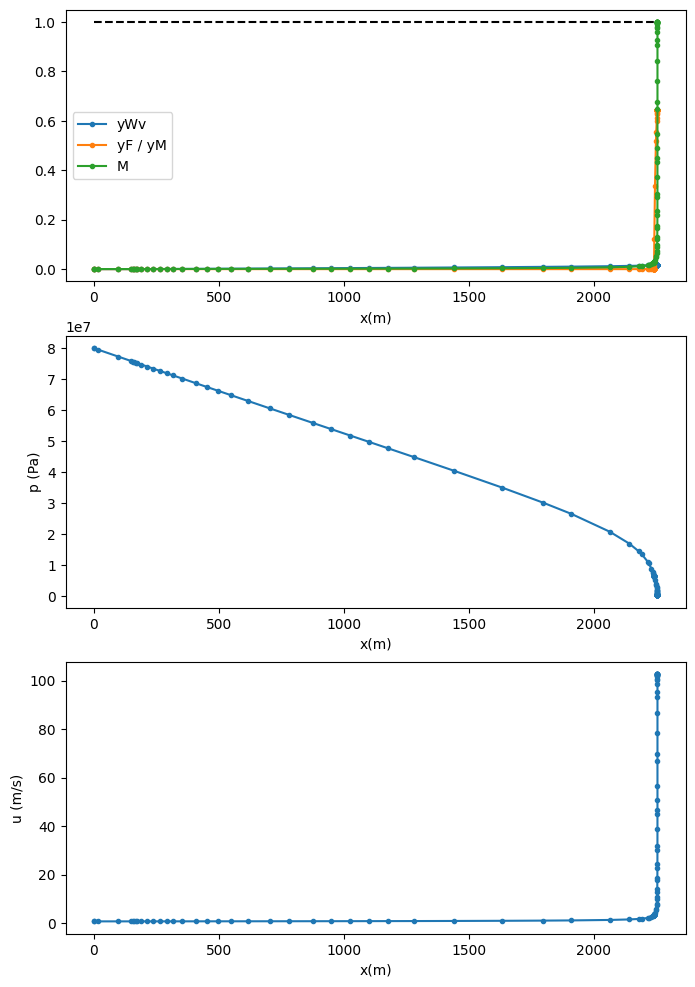

In [ ]:
T0 = 950 + 273.15
# Conduit radius
R0 = 10

# j0 = 400

# yWt_fn = lambda x: 0.03 * np.ones_like(x)
# yC_fn = lambda x: 0.4 * np.ones_like(x)
# yF_fn = lambda x: 0.0 * np.ones_like(x)
# yWv_fn = lambda x: np.interp(x, x_background, yWv_background)

# Left side difference + extend approximation
# dyWv_dx = np.diff(yWv) / np.diff(x)
# dyWv_dx = np.array([*dyWv_dx, dyWv_dx[-1]])

# Parameters
tau_d = 2.5
tau_f = 2.5
vf_g_crit = 0.8
solubility_n = f.solubility_n
solubility_k = f.solubility_k

def RHS(t, q, is_debug_mode=False):
  # Unpack ODE vector
  q = np.asarray(q)
  rho_bar   = q[0,...]
  u         = q[1,...]
  rho_prime = q[2,...]
  yWv       = q[3,...]
  yWt       = q[4,...]
  yC        = q[5,...]
  yF        = q[6,...]
  num_states = q.shape[0]

  '''Compute aliases'''
  T = T0
  yA = 0.0
  yM = 1.0 - yWv
  yWd = yWt - yWv
  yL = (yM - (yC + yWd))
  rho = rho_bar + rho_prime

  '''Compute EOS quantities'''
  ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
  p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
  # Water
  rhoWv = p / (R_wv * T)
  vWv = 1.0 / rhoWv
  vf_g = rho * yWv / rhoWv
  # Magma
  rhoM = rho_m0 * (1 + (p - p_m0) / K)
  vM = 1.0 / rhoM

  # Compute mixture isothermal sound speed, squared
  cT2 = (yM * p * K / rho_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
  # Compute partial of pressure w.r.t. water mass fraction (const rho, T)
  dp_dyw = (-p * (K * rho / rho_m0) + (p + K - p_m0) * rho * R_wv * T) / (2*p - ptilde)
  # Compute partial of density w.r.t. water mass fraction (const p, T)
  drho_dyw = - rho * rho * (vWv - vM)
 
  # Compute solubility based on pure silicate melt mass fraction
  yHat = np.clip(solubility_k * p ** solubility_n * yL, 0, yWt)
  # Compute total steady state advection RHS
  source_yWv = (yWd - yHat) / (tau_d)
  source_yWt = np.zeros_like(p)
  source_yC  = np.zeros_like(p)
  source_yF  = (yM - yF) / (tau_f) * np.asarray(vf_g - vf_g_crit > 0.0).astype(float)
  mu = f.F_fric_viscosity_model(T0, yWv, yF, yWt=yWt, yC=yC)
  F_fric = 8.0*mu/(R0 * R0) * u * np.clip(1.0 - yF/yM, 0.0, 1.0)
  source_momentum = (-rho * 9.8 - F_fric) / rho
  # Compute LHS matrix
  # [rho_bar, u, rho_prime, yWv, yWt, yC, yF]
  A = np.zeros((num_states, num_states))
  A[0,:] = [u, rho, u, -u* drho_dyw, 0, 0, 0]
  A[1,:] = [cT2/rho, u, cT2/rho, dp_dyw/rho , 0, 0, 0]
  A[2,2] = 1.0
  A[[3,4,5,6],[3,4,5,6]] = u

  # Compute source vector
  b = np.stack([-drho_dyw * source_yWv,
                source_momentum,
                0.0,
                source_yWv,
                source_yWt,
                source_yC,
                source_yF,
                ], axis=0)
  
  if is_debug_mode:
    return A, b, np.linalg.solve(A, b), cT2
  return np.linalg.solve(A, b)

class EventIsothermalChoked():
  def __init__(self):
    self.terminal = True
    self.direction = 1.0
  def __call__(self, t, q):
    # Unpack ODE vector
    q = np.asarray(q)
    rho_bar   = q[0,...]
    u         = q[1,...]
    rho_prime = q[2,...]
    yWv       = q[3,...]
    yWt       = q[4,...]
    yC        = q[5,...]
    yF        = q[6,...]
    rho = rho_bar + rho_prime
    # Compute dependent quantites
    yA = 0.0
    yM = 1.0 - yWv
    T = T0
    # Compute pressure
    ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
    p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
    # Compute mixture isothermal sound speed, squared
    cT2 = (yM * p * K / rho_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
    return u*u/cT2

def pressure(q):
  q = np.asarray(q)
  rho_bar   = q[0,...]
  u         = q[1,...]
  rho_prime = q[2,...]
  yWv       = q[3,...]
  yWt       = q[4,...]
  yC        = q[5,...]
  yF        = q[6,...]
  rho = rho_bar + rho_prime
  # Compute dependent quantites
  yA = 0.0
  yM = 1.0 - yWv
  T = T0
  # Compute pressure
  ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
  p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
  return p

def isoT_mach_fn(q):
  # Unpack ODE vector
    q = np.asarray(q)
    rho_bar   = q[0,...]
    u         = q[1,...]
    rho_prime = q[2,...]
    yWv       = q[3,...]
    yWt       = q[4,...]
    yC        = q[5,...]
    yF        = q[6,...]
    rho = rho_bar + rho_prime
    # Compute dependent quantites
    yA = 0.0
    yM = 1.0 - yWv
    T = T0
    # Compute pressure
    ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
    p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
    # Compute mixture isothermal sound speed, squared
    cT2 = (yM * p * K / rho_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
    return np.sqrt(u*u/cT2)

# Inlet
p0 = 80e6
yWt0 = 0.025
yC0 = 0.4
yF0 = 0.0
# Compute phase mass fractions from solubility
xi = solubility_k * p0 ** solubility_n
yWd0 = np.clip(xi *(1.0 - (yWt0 + yC0)), 0, yWt0)
yWv0 = yWt0 - yWd0
yM0 = 1.0 - yWv0
# Compute densities
rhoM0 = rho_m0 * (1 + (p0 - p_m0) / K)
vM0 = 1.0 / rhoM0
vWv0 = R_wv * T0 / p0
v0 = yM0 * vM0 + yWv0 * vWv0
rho0 = 1.0 / v0
# Assemble initial condition
q0 = np.array([rho0, 0.7, 0, yWv0, yWt0, yC0, yF0])


soln_steady = scipy.integrate.solve_ivp(RHS,
        (0, 5000),
        q0,
        method="Radau",
        dense_output=True,
        # max_step=1.0,
        events=[EventIsothermalChoked(),])
# Output solution
soln_state = soln_steady.y

plt.figure(figsize=(8,12))

# [rho_bar, u, rho_prime, yWv, yWt, yC, yF]
plt.subplot(3,1,1)
plt.plot(soln_steady.t, soln_steady.y[3,:], '.-')
plt.plot(soln_steady.t, soln_steady.y[6,:] / (1 - soln_steady.y[3,:]), '.-')
plt.plot(soln_steady.t, isoT_mach_fn(soln_steady.y), '.-')
plt.plot(soln_steady.t, np.ones_like(soln_steady.t), 'k--')
plt.xlabel("x(m)")
plt.legend(["yWv", "yF / yM", "M"])

_p = pressure(soln_steady.y)
plt.subplot(3,1,2)
plt.plot(soln_steady.t, _p, '.-')
plt.xlabel("x(m)")
plt.ylabel("p (Pa)")

plt.subplot(3,1,3)
plt.plot(soln_steady.t, soln_steady.y[1,:].ravel(), '.-')
plt.xlabel("x(m)")
plt.ylabel("u (m/s)")

# yL0 = yM0 - (yC0 + yWd0)
# yL0 * solubility_k * p0 ** solubility_n, yWd0, yL0, 1 - (yC0 + yWt0)

#### Split into wave-scale and advection-scale equations

In [ ]:
import scipy.interpolate

# Interpolate test
# _interp = scipy.interpolate.PchipInterpolator(soln.t, soln.y[3,:], extrapolate=True)
# _interp([10.0, 4950.0])
# _interp_d1 = _interp.derivative()
# _x = np.linspace(0,5000,1000)
# plt.plot(_x, _interp(_x))
# plt.plot(_x, _interp_d1(_x))


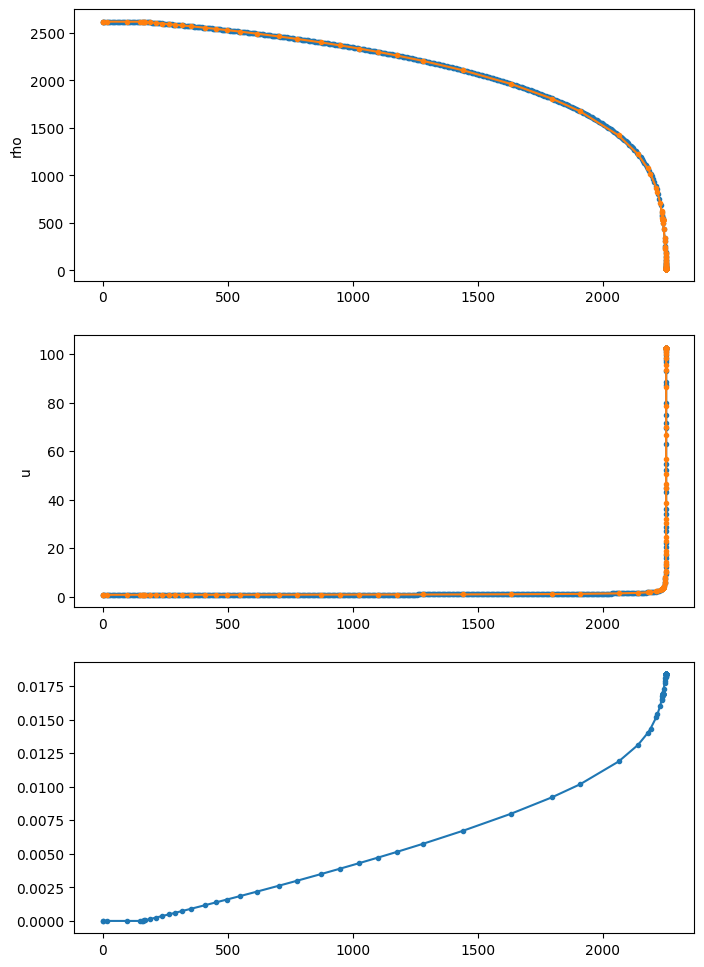

In [ ]:
# # Iso temperature
# T0 = 950 + 273.15
# # Conduit radius
# R0 = 10

# # Parameters
# tau_d = 2.5
# tau_f = 2.5
# vf_g_crit = 0.8
# solubility_n = f.solubility_n
# solubility_k = f.solubility_k
# # Viscosity model
F_fric_viscosity_model = f.F_fric_viscosity_model

def pressure(q):
  ''' Compute pressure from full state vector '''
  q = np.asarray(q)
  rho_bar   = q[0,...]
  u         = q[1,...]
  rho_prime = q[2,...]
  yWv       = q[3,...]
  yWt       = q[4,...]
  yC        = q[5,...]
  yF        = q[6,...]
  rho = rho_bar + rho_prime
  # Compute dependent quantites
  yA = 0.0
  yM = 1.0 - yWv
  T = T0
  # Compute pressure
  ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
  p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
  return p

def time_indep_RHS(t, q2, r_interpolants:list, is_debug_mode=False):
  # Unpack ODE vector
  q2 = np.asarray(q2)
  # Interpolate solution for time-dependent quantities
  r = np.array([interpolant(t) for interpolant in r_interpolants]) 

  rho_bar   = q2[0,...]
  u         = q2[1,...]
  rho_prime = r[0,...]
  yWv       = r[1,...]
  yWt       = r[2,...]
  yC        = r[3,...]
  yF        = r[4,...]

  # Extract unsteady term for yw; TODO: use the correct repr for this
  dyw_dt = 0.0
  # Extract spatial derivative of rho prime
  drho_prime_dx = r_interpolants[0].derivative()(t)
  # if np.any(drho_prime_dx != 0):
  #   raise Exception("test by crashing")
  dyw_dx        = r_interpolants[1].derivative()(t)

  '''Compute aliases'''
  T = T0
  yA = 0.0
  yM = 1.0 - yWv
  yWd = yWt - yWv
  yL = (yM - (yC + yWd))
  rho = rho_bar + rho_prime

  '''Compute EOS quantities'''
  ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
  p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
  # Water
  rhoWv = p / (R_wv * T)
  vWv = 1.0 / rhoWv
  vf_g = rho * yWv / rhoWv
  # Magma
  rhoM = rho_m0 * (1 + (p - p_m0) / K)
  vM = 1.0 / rhoM

  # Compute mixture isothermal sound speed, squared
  cT2 = (yM * p * K / rho_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
  # Compute partial of pressure w.r.t. water mass fraction (const rho, T)
  dp_dyw = (-p * (K * rho / rho_m0) + (p + K - p_m0) * rho * R_wv * T) / (2*p - ptilde)
  # Compute partial of density w.r.t. water mass fraction (const p, T)
  drho_dyw = - rho * rho * (vWv - vM)
 
  # Compute solubility based on pure silicate melt mass fraction
  yHat = np.clip(solubility_k * p ** solubility_n * yL, 0, yWt)
  # Compute total steady state advection RHS
  source_yWv = (yWd - yHat) / (tau_d)
  source_yWt = np.zeros_like(p)
  source_yC  = np.zeros_like(p)
  source_yF  = (yM - yF) / (tau_f) * np.asarray(vf_g - vf_g_crit > 0.0).astype(float)
  mu = F_fric_viscosity_model(T0, yWv, yF, yWt=yWt, yC=yC)
  F_fric = 8.0*mu/(R0 * R0) * u * np.clip(1.0 - yF/yM, 0.0, 1.0)
  source_momentum = (-rho * 9.8 - F_fric) / rho
  # Compute inverted LHS matrix
  #   for state vector [rho_bar, u]
  Ainv = np.array([[u, -rho], [-cT2/rho, u]]) / (u*u - cT2)

  # Compute source vector
  # if (np.linalg.norm((u * dyw_dx - source_yWv))) > 0.1:
  #   print(f"t: {t}, u: {u}, dydx: {dyw_dx}, source: {source_yWv}, p: {p}")
  b = np.stack([-u * drho_prime_dx + drho_dyw * dyw_dt,
                -cT2 / rho * drho_prime_dx - 1.0 / rho * dp_dyw * dyw_dx + source_momentum,
                ], axis=0)

  # print(Ainv)
  # print(b)
  # print(Ainv @ b - np.einsum("ij, j -> i", Ainv, b))
  # raise Exception
  if is_debug_mode:
    return Ainv @ b
  return Ainv @ b

class EventIsothermalChoked():
  def __init__(self, r_interpolants):
    self.terminal = True
    self.direction = 1.0
    self.r_interpolants = r_interpolants
  def __call__(self, t, q):
    # Unpack ODE vector
    q = np.asarray(q)
    rho_bar   = q[0,...]
    u         = q[1,...]
    # Interpolate solution for time-dependent quantities
    r = np.array([interpolant(t) for interpolant in self.r_interpolants]) 
    rho_prime = r[0,...]
    yWv       = r[1,...]
    yWt       = r[2,...]
    yC        = r[3,...]
    yF        = r[4,...]
    rho = rho_bar + rho_prime
    # Compute dependent quantites
    yA = 0.0
    yM = 1.0 - yWv
    T = T0
    # Compute pressure
    ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
    p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
    # Compute mixture isothermal sound speed, squared
    cT2 = (yM * p * K / rho_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
    return u*u/cT2

def isoT_mach_fn(q):
  # Unpack ODE vector
    q = np.asarray(q)
    rho_bar   = q[0,...]
    u         = q[1,...]
    rho_prime = q[2,...]
    yWv       = q[3,...]
    yWt       = q[4,...]
    yC        = q[5,...]
    yF        = q[6,...]
    rho = rho_bar + rho_prime
    # Compute dependent quantites
    yA = 0.0
    yM = 1.0 - yWv
    T = T0
    # Compute pressure
    ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
    p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
    # Compute mixture isothermal sound speed, squared
    cT2 = (yM * p * K / rho_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
    return np.sqrt(u*u/cT2)

# Inlet
p0 = 80e6
u0 = 0.7
yWt0 = 0.025
yC0 = 0.4
yF0 = 0.0
# Compute phase mass fractions from solubility
xi = solubility_k * p0 ** solubility_n
yWd0 = np.clip(xi *(1.0 - (yWt0 + yC0)), 0, yWt0)
yWv0 = yWt0 - yWd0
yM0 = 1.0 - yWv0
# Compute densities
rhoM0 = rho_m0 * (1 + (p0 - p_m0) / K)
vM0 = 1.0 / rhoM0
vWv0 = R_wv * T0 / p0
v0 = yM0 * vM0 + yWv0 * vWv0
rho0 = 1.0 / v0
# Assemble initial condition
q0 = np.array([rho0, u0, 0, yWv0, yWt0, yC0, yF0])

q0_time_indep = np.array([rho0, u0])

# Step 0 interpolators
r_interpolants = [scipy.interpolate.PchipInterpolator(soln_steady.t, soln_steady.y[i,:], extrapolate=True)
           for i in range(2,7)]
soln = scipy.integrate.solve_ivp(
  lambda t, q: time_indep_RHS(t, q, r_interpolants, is_debug_mode=False),
  (0, 5000),
  q0_time_indep,
  method="Radau",
  dense_output=True,
  max_step=5.0,
  events=[EventIsothermalChoked(r_interpolants),])
# Output solution
soln_state = soln.y

plt.figure(figsize=(8,12))

# [rho_bar, u, rho_prime, yWv, yWt, yC, yF]
plt.subplot(3,1,1)
plt.plot(soln.t, soln.y[0,:], '.-')
plt.plot(soln_steady.t, soln_steady.y[0,:], '.-')
plt.ylabel("rho")

plt.subplot(3,1,2)
plt.plot(soln.t, soln.y[1,:], '.-')
plt.plot(soln_steady.t, soln_steady.y[1,:], '.-')
plt.ylabel("u")

plt.subplot(3,1,3)
# plt.plot(soln.t, soln.y[1,:], '.-')
plt.plot(soln_steady.t, soln_steady.y[3,:], '.-')

In [ ]:
''' Check yW imbalance '''
def yW_imbalance(t, q2, r_interpolants, is_debug_mode=False):
  # Unpack ODE vector
  q2 = np.asarray(q2)
  # Interpolate solution for time-dependent quantities
  r = np.array([interpolant(t) for interpolant in r_interpolants]) 

  rho_bar   = q2[0,...]
  u         = q2[1,...]
  rho_prime = r[0,...]
  yWv       = r[1,...]
  yWt       = r[2,...]
  yC        = r[3,...]
  yF        = r[4,...]

  # Compute derivatives
  drho_prime_dx = r_interpolants[0].derivative()(t)
  # if np.any(drho_prime_dx != 0):
  #   raise Exception("test by crashing")
  dyw_dx        = r_interpolants[1].derivative()(t)

  '''Compute aliases'''
  T = T0
  yA = 0.0
  yM = 1.0 - yWv
  yWd = yWt - yWv
  yL = (yM - (yC + yWd))
  rho = rho_bar + rho_prime

  '''Compute EOS quantities'''
  ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
  p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
  # Water
  rhoWv = p / (R_wv * T)
  vWv = 1.0 / rhoWv
  vf_g = rho * yWv / rhoWv
  # Magma
  rhoM = rho_m0 * (1 + (p - p_m0) / K)
  vM = 1.0 / rhoM

  # Compute mixture isothermal sound speed, squared
  cT2 = (yM * p * K / rho_m0 + yWv * (p + K - p_m0) * R_wv * T) / (2*p - ptilde)
  # Compute partial of pressure w.r.t. water mass fraction (const rho, T)
  dp_dyw = (-p * (K * rho / rho_m0) + (p + K - p_m0) * rho * R_wv * T) / (2*p - ptilde)
  # Compute partial of density w.r.t. water mass fraction (const p, T)
  drho_dyw = - rho * rho * (vWv - vM)
 
  # Compute solubility based on pure silicate melt mass fraction
  yHat = np.clip(solubility_k * p ** solubility_n * yL, 0, yWt)
  # Compute total steady state advection RHS
  source_yWv = (yWd - yHat) / (tau_d)
  
  return (u * dyw_dx - source_yWv)

ff = lambda t, q: yW_imbalance(t, q, r_interpolants, is_debug_mode=False)
z = ff(soln_steady.t, soln_steady.y[0:2,...])

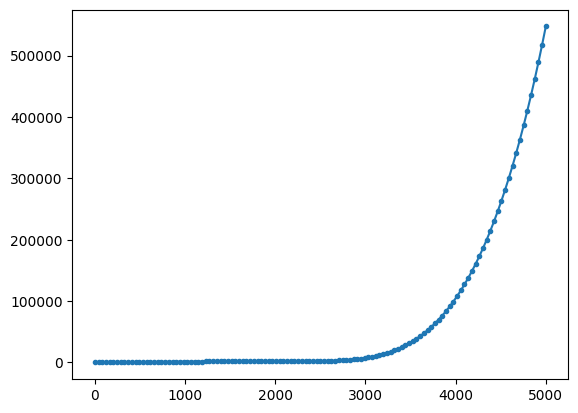

In [ ]:
# Slowness integration

slowness_integration = scipy.integrate.solve_ivp(
  lambda t, x: 1.0 / soln.sol(x)[1,...],
  (soln.t.min(), soln.t.max()),
  np.array([0.0]),
  dense_output=True)
_x_range = np.linspace(0,5000,123)
plt.plot(_x_range, slowness_integration.sol(_x_range).ravel(), '.-')

In [ ]:
import scipy.sparse
Nx = x.size
_main_diag = -np.ones((Nx,))
_main_diag[0] = +1.0
_sub_diag = np.ones((Nx-1,))
_D = scipy.sparse.diags((_main_diag, _sub_diag,), (0,-1))
_D.todense()[1,:]
_D.shape

(1400, 1400)

dt = 2.0


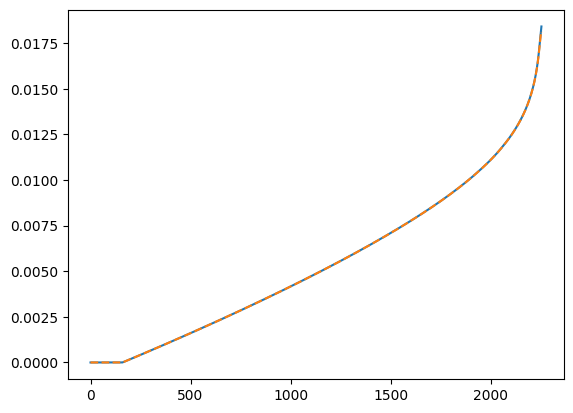

In [ ]:
# Unsteady part
#   for variables [rho_prime, yWv, yWt, yC, yF]

dx = 1

t = 0
''' Gridded advection '''
# Set desired CFL
CFL = 0.5
dt = CFL * dx / np.abs(u).max()
dt = 2.0

print(f"dt = {dt}")

BC = lambda t: np.stack((
  rho0 * np.ones_like(t),
  u0 * np.ones_like(t),
  0.0 * np.ones_like(t), # rho_prime0,
  yWv0 * np.ones_like(t),
  yWt0 * np.ones_like(t),
  yC0 * np.ones_like(t),
  yF0 * np.ones_like(t),
), axis=0)

# Grid
x = np.linspace(soln_steady.t.min(), soln_steady.t.max(), 1400)

# Advection foot point (x - ut) using RK2
x1 = x - dt * soln.sol(x)[1,...]
x2 = x - dt * soln.sol(x1)[1,...]
x_origin = 0.5 * (x1 + x2) # TODO: check properties
x_origin = x2
# Send negative origin to t using u(x = 0)
q_origin = np.where(x_origin >= 0,
                    soln_steady.sol(x_origin),
                    BC(t - x_origin / soln.sol(0)[1,...]))

# Plot advected solution
plt.plot(x, soln_steady.sol(x)[3,:], '-')
plt.plot(x, q_origin[3,:], '.-')

def t_dep_RHS(x, q5, q2_interpolants, is_debug_mode=False):
  ''' Full gridded RHS for d/dt consistency '''
  q2 = q2_interpolants(x)
  rho_bar = q2[0,...]
  u = q2[1,...]
  # Unpack ODE vector
  q5 = np.asarray(q5)
  rho_prime = q5[0,...]
  yWv       = q5[1,...]
  yWt       = q5[2,...]
  yC        = q5[3,...]
  yF        = q5[4,...]

  ''' Compute aliases '''
  T = T0
  yA = 0.0
  yM = 1.0 - yWv
  yWd = yWt - yWv
  yL = (yM - (yC + yWd))
  rho = rho_bar + rho_prime

  ''' Compute EOS quantities '''
  ptilde = K * (yM * rho / rho_m0 - 1.0) + p_m0 + rho * (yA * R_a + yWv * R_wv) * T
  p = 0.5 * (ptilde + np.sqrt(ptilde*ptilde + 4 * rho * (yA * R_a + yWv * R_wv) * T * (K - p_m0)))
  # Water
  rhoWv = p / (R_wv * T)
  vWv = 1.0 / rhoWv
  vf_g = rho * yWv / rhoWv
  # Magma
  rhoM = rho_m0 * (1 + (p - p_m0) / K)
  vM = 1.0 / rhoM

  ''' Compute slopes '''
  # Compute partial of density w.r.t. water mass fraction (const p, T)
  drho_dyw = - rho * rho * (vWv - vM)
 
  ''' Split 1/2: gridded advection'''
  # Rudimentary upwind stencil without boundary term
  RHS_advection = (u / dx) * _D.dot(q5.T).T

  # Boundary SAT
  tau = np.abs(u)[0]
  RHS_advection[...,0] += (tau / dx) * (BC(x[0])[2:,...] - q5[...,0])
  # Replace non-advected rho_prime terms
  RHS_advection[0,...] = drho_dyw * RHS_advection[1,...]

  # Compute solubility based on pure silicate melt mass fraction
  yHat = np.clip(solubility_k * p ** solubility_n * yL, 0, yWt)
  # Compute total steady state advection RHS
  ddt_yWv = (yWd - yHat) / (tau_d)
  ddt_yWt = np.zeros_like(p)
  ddt_yC  = np.zeros_like(p)
  ddt_yF  = (yM - yF) / (tau_f) * np.asarray(vf_g - vf_g_crit > 0.0).astype(float)
  # Compute source vector for reaction terms
  #   [rho_prime, yWv, yWt, yC, yF]
  RHS_source = np.stack([drho_dyw * ddt_yWv,
                         ddt_yWv,
                         ddt_yWt,
                         ddt_yC,
                         ddt_yF,
                        ], axis=0)
  if is_debug_mode:
    return RHS_advection, RHS_source
  else:
    return RHS_advection + RHS_source

plt.clf()

q_test = soln_steady.sol(x)[2:,...]
RHS_advection, RHS_source = t_dep_RHS(x, q_test, soln.sol, is_debug_mode=True)
q_stepped = q_test + .1 * dt * (RHS_advection + RHS_source)
plt.plot(x, q_test[1,...])
plt.plot(x, q_stepped[1,...], '--')
# plt.plot(dt * RHS_advection[1,...])
# plt.plot(x, q_origin[1,...], 'r--')
# plt.xlim(2200,2300)

# plt.legend(["q_k", "q_k - grid", "q_k - exactvection"])
# RHS_advection[:,100]

# [rho_prime, yWv, yWt, yC, yF]
# _i = 1
# plt.plot(x, q_origin[2+_i,...] + dt * t_dep_RHS(x, q_origin[2:,...], soln.sol)[_i,...])
# plt.plot(x, soln.sol(x)[1,...])

# x_origin.shape

# Grid representation
# q_grid = soln_steady.sol(x)


# ddt_yWv =
# ddt_yWt = 
# ddt_yC = 
# ddt_yF = 

# ddt_rho_prime = 

C:\Users\fredr\AppData\Local\Temp\ipykernel_7364\2527819263.py:68: RuntimeWarning: divide by zero encountered in divide
  vWv = 1.0 / rhoWv
C:\Users\fredr\AppData\Local\Temp\ipykernel_7364\2527819263.py:69: RuntimeWarning: divide by zero encountered in divide
  vf_g = rho * yWv / rhoWv
C:\Users\fredr\AppData\Local\Temp\ipykernel_7364\2527819263.py:69: RuntimeWarning: invalid value encountered in divide
  vf_g = rho * yWv / rhoWv
C:\Users\fredr\AppData\Local\Temp\ipykernel_7364\2527819263.py:86: RuntimeWarning: invalid value encountered in multiply
  RHS_advection[0,...] = drho_dyw * RHS_advection[1,...]
C:\Users\fredr\AppData\Local\Temp\ipykernel_7364\4153084422.py:3: RuntimeWarning: invalid value encountered in add
  q_stepped = q_test + .1 * dt * (RHS_advection + RHS_source)


ValueError: `y` must contain only finite values.

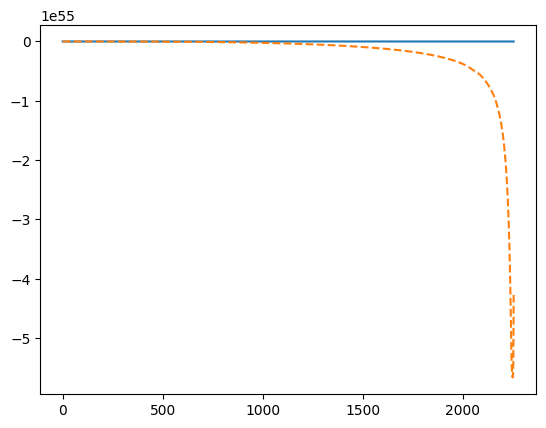

In [ ]:
q_test = soln_steady.sol(x)[2:,...]
RHS_advection, RHS_source = t_dep_RHS(x, q_test, soln.sol, is_debug_mode=True)
q_stepped = q_test + .1 * dt * (RHS_advection + RHS_source)
plt.plot(x, q_test[1,...])
plt.plot(x, q_stepped[1,...], '--')

# Interpolate to free domain
q_stepped_interp = scipy.interpolate.pchip(x, q_stepped.T)

# Step 0 interpolators
r_interpolants = [scipy.interpolate.PchipInterpolator(soln_steady.t, soln_steady.y[i,:], extrapolate=True)
           for i in range(soln_steady.y.shape[0])]
soln = scipy.integrate.solve_ivp(
  lambda t, q: time_indep_RHS(t, q, r_interpolants, is_debug_mode=False),
  (0, 5000),
  q0_time_indep,
  method="Radau",
  dense_output=True,
  max_step=5.0,
  events=[EventIsothermalChoked(r_interpolants),])
# Output solution
soln_state = soln.y

In [ ]:
# Inlet
p0 = 80e6
u0 = 0.7
yWt0 = 0.025
yC0 = 0.4
yF0 = 0.0
# Compute phase mass fractions from solubility
xi = solubility_k * p0 ** solubility_n
yWd0 = np.clip(xi *(1.0 - (yWt0 + yC0)), 0, yWt0)
yWv0 = yWt0 - yWd0
yM0 = 1.0 - yWv0
# Compute densities
rhoM0 = rho_m0 * (1 + (p0 - p_m0) / K)
vM0 = 1.0 / rhoM0
vWv0 = R_wv * T0 / p0
v0 = yM0 * vM0 + yWv0 * vWv0
rho0 = 1.0 / v0
# Assemble initial condition
q0 = np.array([rho0, u0, 0, yWv0, yWt0, yC0, yF0])

q0_time_indep = np.array([rho0, u0])

# Step 0 interpolators
r_interpolants = [scipy.interpolate.PchipInterpolator(soln_steady.t, soln_steady.y[i,:], extrapolate=True)
           for i in range(2,7)]
soln = scipy.integrate.solve_ivp(
  lambda t, q: time_indep_RHS(t, q, r_interpolants, is_debug_mode=False),
  (0, 5000),
  q0_time_indep,
  method="Radau",
  dense_output=True,
  max_step=5.0,
  events=[EventIsothermalChoked(r_interpolants),])
# Output solution
soln_state = soln.y

## Library version of Low-Mach number approximation

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import scipy
import scipy.interpolate
import matplotlib.pyplot as plt

In [2]:
# Set up arbitrary SteadyState object for borrowing viscosity model

# PC:
locale = r"C:\Users\Fredric\Documents\Volcano\quail_volcano\src\compressible_conduit_steady"
import os
os.chdir(locale)
import steady_state

x_km_range = np.linspace(0, 15000, 100)
f = steady_state.SteadyState(x_km_range, 1e5, 100e6, input_type="p",
                             override_properties={
                               "tau_f": 1e0, # 1e-2,
                               "tau_d": 1e0, # 1e-2,
                              #  "yWt": 0.05,
                               "yC": 0.4,
                               "rho0_magma": 2.6e3,
                             }, skip_rootfinding=True)

In [5]:
from scipy.special import erf
def loc_F_fric_viscosity_model(T, y, yF, yWt=0.03, yC=0.4):
    ''' Calculates the viscosity as a function of dissolved
    water and crystal content (assumes crystal phase is incompressible)/
    Does not take into account fragmented vs. not fragmented (avoiding
    double-dipping the effect of fragmentation).
    '''
    # Calculate pure melt viscosity (Hess & Dingwell 1996)
    yWd = yWt - y
    yM = 1.0 - y
    yL = yM - (yWd + yC)
    mfWd = yWd / yL # mass concentration of dissolved water
    mfWd = np.where(mfWd <= 0.0, 1e-8, mfWd)
    log_mfWd = np.log(mfWd*100)
    log10_vis = -3.545 + 0.833 * log_mfWd
    log10_vis += (9601 - 2368 * log_mfWd) / (T - 195.7 - 32.25 * log_mfWd)
    # Prevent overflowing float
    log10_vis = np.where(log10_vis > 300, 300, log10_vis)
    meltVisc = 10**log10_vis
    # Calculate relative viscosity due to crystals (Costa 2005).
    alpha = 0.999916
    phi_cr = 0.673
    gamma = 3.98937
    delta = 16.9386
    B = 2.5
    # Compute volume fraction of crystal at equal phasic densities
    # Using crystal volume per (melt + crystal + dissolved water) volume
    phi_ratio = np.clip((yC / yM) / phi_cr, 0.0, None)
    erf_term = erf(
      np.sqrt(np.pi) / (2 * alpha) * phi_ratio * (1 + phi_ratio**gamma))
    crysVisc = (1 + phi_ratio**delta) * ((1 - alpha * erf_term)**(-B * phi_cr))
    
    viscosity = meltVisc * crysVisc
    return viscosity

In [6]:
import lowM_split
import importlib
importlib.reload(lowM_split)

params = {
  "T0": 950+273.15,
  "conduit_radius": 10,
  "tau_d": 5., # CHECK, and Euler stability; next: most likely need BVP with p BCs instead of this
  "tau_f": .25, # TODO: add resonant case for tau_f == tau_d
  "vf_g_crit": 0.8,
  "solubility_n": f.solubility_n,
  "solubility_k": f.solubility_k,
  "K": 10e9,
  "rho_m0": 2.7e3,
  "p_m0": 5e6,
  "R_wv": f.mixture.waterEx.R,
  "F_fric_viscosity_model": loc_F_fric_viscosity_model,
}

# Remember: Nx needs enough resolution of the front as well
split_solver = lowM_split.SplitSolver(params, Nt=1000)
q2, q5 = split_solver.full_solve((0,2100), Nx=2001, p0=80e6, u0=0.4, yWt0=0.025,
                 yC0=0.4, yF0=0.0, CFL=1)
print(f"Final t: {split_solver.t} s")

c:\Users\Fredric\OneDrive\Documents\lowM_split.py:77: RuntimeWarning: invalid value encountered in double_scalars
  return rho * yWv / rhoWv
c:\Users\Fredric\OneDrive\Documents\lowM_split.py:69: RuntimeWarning: divide by zero encountered in double_scalars
  vWv = 1.0 / rhoWv
c:\Users\Fredric\OneDrive\Documents\lowM_split.py:83: RuntimeWarning: invalid value encountered in double_scalars
  return np.clip(self.solubility_k * p ** self.solubility_n * yL, 0, yWt)
c:\Python39\lib\site-packages\scipy\interpolate\_cubic.py:289: RuntimeWarning: overflow encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
c:\Python39\lib\site-packages\scipy\interpolate\_cubic.py:289: RuntimeWarning: overflow encountered in add
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Final t: 1558.81204950578 s


State of the solver: for tau_d > 5.0, the solver seems to work fine. When tau_d is smaller, consider the following effect on the mass-momentum steady-state system. Approximately,

``` dp/dx ~ - u / c_T^2 * dp/dy * Y_source + friction_source ```

and since dp/dy can be large, the effect of exsolution on pressure can be strong. Consider leaving tau_d large, while tau_f can be made smaller with grid refinement (and not necessarily respecting CFL if a wider stencil, or the exact advection of the interpolation of the solution, is used). Otherwise, there is no guarantee of positivity of -dp/dx, since Y_source can be positive or negative.

Alternatively, consider the limit tau_d -> 0, tau_f -> and solve the further reduced model.

It is possible that the (p0, u0) boundary condition is not compatible with a monotonically decreasing pressure. The region of validity remains to be found. The more interesting boundary condition is the (p_bottom, p_top) boundaries, which requires a BVP solver (see for example `scipy.integrate.solve_bvp` for an adaptive method). The top-bottom boundary conditions allows us to place the fragmentation front inside, and not chop off the acceleration region where the fragmented gas accelerates to choking.

The current numerical strategy is: 1) interpolate q5 (unsteady variables); 2) interpolate u (quasi-steady velocity); 3) advect q5 along u by an RK2 integration of the particle path, resulting in the advected solution on a uniform grid for duration dt; 4) solve on the uniform grid the exsolution part exactly, and the fragmentation part approximately (does not detect onset of fragmentation within a timestep); 5) interpolate the advanced q5; 6) solve the QSS equations q2 using `solve_ivp`. The interpolation is done using pchip, which is a cubic spline that is monotonic between data points.

One can improve by 1) improving splitting error; 2) improving integration along particle paths for advection; 3) improving detection of fragmentation onset within a timestep.

(37025.86600324163, 192.42106434390604)

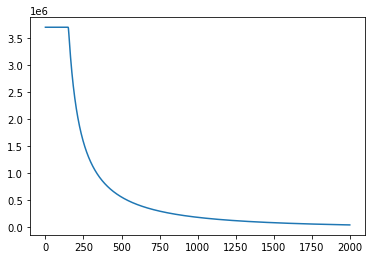

In [7]:
idx_t = 1
yWv = split_solver.out_q5[idx_t,1,:]
p = split_solver.out_q2[idx_t,0,:]
rho = split_solver.rho_p(yWv, p)

cT2 = split_solver.isothermal_sound_speed_squared(yWv,
                                            *split_solver.p_ptilde(rho, yWv))
plt.plot(cT2)
cT2.min(), np.sqrt(cT2.min())

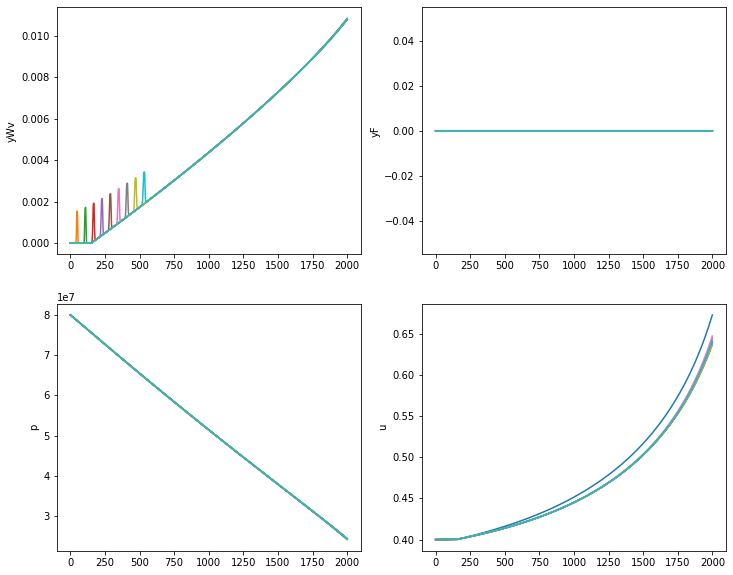

In [8]:
plt.figure(figsize=(12,10))
for idx_t in range(0,1000,100):
  plt.subplot(2,2,1)
  plt.plot(split_solver.out_q5[idx_t,1,:])
  plt.ylabel("yWv")
  plt.subplot(2,2,2)
  plt.plot(split_solver.out_q5[idx_t,4,:])
  plt.ylabel("yF")
  plt.subplot(2,2,3)
  plt.plot(split_solver.out_q2[idx_t,0,:])
  plt.ylabel("p")
  plt.subplot(2,2,4)
  plt.plot(split_solver.out_q2[idx_t,1,:])
  plt.ylabel("u")


'The solver successfully reached the end of the integration interval.'

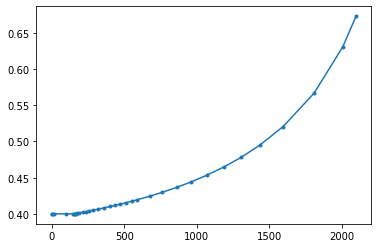

In [9]:
plt.plot(split_solver._soln_steady.t, split_solver._soln_steady.y[1,:], '.-')
split_solver._soln_steady.message

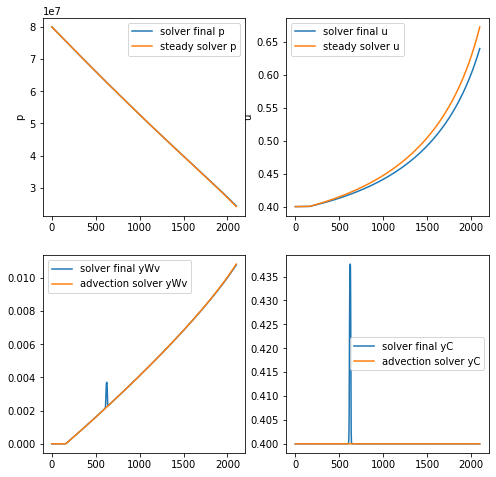

In [10]:
''' Output comparison '''

# Compute steady state pressure
_rho = split_solver._soln_steady.sol(split_solver.x)[0,...]
_yWv = split_solver._soln_steady.sol(split_solver.x)[3,...]
steady_p = split_solver.p_ptilde(_rho, _yWv)[0]

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(split_solver.x, split_solver.q2[0,:])
plt.plot(split_solver.x, steady_p)
plt.legend(["solver final p", "steady solver p"])
plt.ylabel("p")
plt.subplot(2,2,2)
plt.plot(split_solver.x, split_solver.q2[1,:])
plt.plot(split_solver.x, split_solver._soln_steady.sol(split_solver.x)[1,:])
plt.ylabel("u")
plt.legend(["solver final u", "steady solver u"])
plt.subplot(2,2,3)
plt.plot(split_solver.x, split_solver.q5[1,:])
plt.plot(split_solver.x, split_solver._soln_steady.sol(split_solver.x)[3,:])
plt.legend(["solver final yWv", "advection solver yWv"])
plt.subplot(2,2,4)
plt.plot(split_solver.x, split_solver.q5[3,:])
plt.plot(split_solver.x, split_solver._soln_steady.sol(split_solver.x)[5,:])
plt.legend(["solver final yC", "advection solver yC"])

yC source-time function


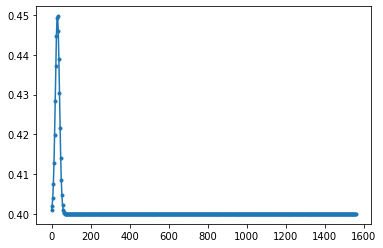

In [11]:
_t = np.linspace(0, split_solver.t, 500)
BC_vals = np.array([split_solver.BC_gaussian(t) for t in _t])
plt.plot(_t, BC_vals[:,5], '.-')
print("yC source-time function")

#### Detailed debug

In [ ]:
# Check interpolation of q5
q5_first = split_solver.cache3[0]
first_interpolant = scipy.interpolate.PchipInterpolator(split_solver.x,
                                                           q5_first,
                                                           extrapolate=True,
                                                           axis=1)
_x = np.linspace(split_solver.x[0], split_solver.x[-1], 1000)
plt.plot(_x, first_interpolant(_x)[1,:], '-')
plt.plot(split_solver.x, q5_first[1,:], '.')


In [35]:
# Check sensitivity for density formulation
if False:
  # Density formulation
  p, ptilde = split_solver.p_ptilde(split_solver.cache2[0][0,:]*(1-.001),
                                    split_solver.cache3[0][1,...]*(1+.01))
  plt.plot(split_solver.x, p.ravel())
  p, ptilde = split_solver.p_ptilde(split_solver.cache2[0][0,:]*(1+.001),
                                    split_solver.cache3[0][1,...]*(1+.01))
  plt.plot(split_solver.x, p.ravel())
  plt.title("Density plus-minus sensitivity")

yWv source components (blue: adv, orange: source, green: sum)


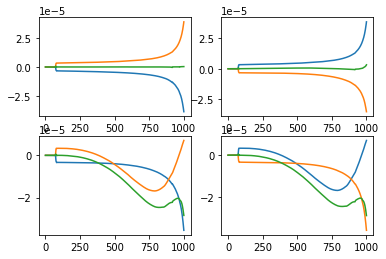

In [46]:
for j in range(4):
  plt.subplot(2,2,j+1)
  plt.plot(split_solver.cache[j+0][1,:])
  plt.plot(split_solver.cache[j+1][1,:])
  plt.plot(split_solver.cache[j+0][1,:] + split_solver.cache[j+1][1,:])
print("yWv source components (blue: adv, orange: source, green: sum)")

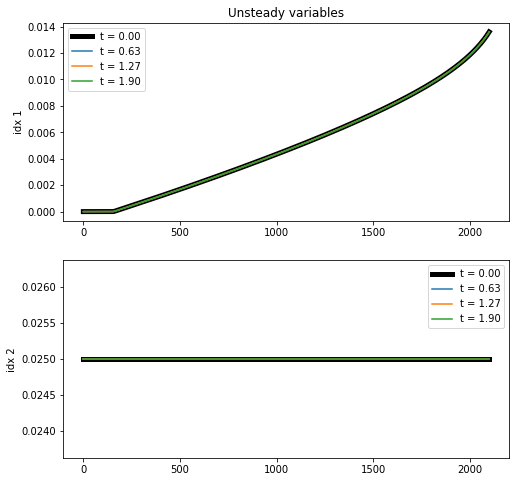

In [48]:
# Unsteady variables

cache_length = 3

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
# Index for quantity within q5 subvector
q5_idx = 1
plt.plot(split_solver.x,
         split_solver._soln_steady.sol(split_solver.x)[2+q5_idx,...],
         'k',
         linewidth=5)
for cache_idx in range(cache_length):
  plt.plot(split_solver.x, split_solver.cache3[cache_idx][q5_idx,:])
  plt.ylabel(f"idx {q5_idx}")
  plt.legend([f"t = {split_solver.dt*i:.2f}" for i in range(cache_length+1)])
plt.title("Unsteady variables")

plt.subplot(2,1,2)
q5_idx = 2
plt.plot(split_solver.x,
         split_solver._soln_steady.sol(split_solver.x)[2+q5_idx,...],
         'k',
         linewidth=5)
for cache_idx in range(cache_length):
  plt.plot(split_solver.x, split_solver.cache3[cache_idx][q5_idx,:])
  plt.ylabel(f"idx {q5_idx}")
  plt.legend([f"t = {split_solver.dt*i:.2f}" for i in range(cache_length+1)])
# plt.plot(split_solver.x, split_solver._soln_steady.sol(split_solver.x)[1,...], 'k', linewidth=5)
# for cache_idx in range(3):
#   plt.plot(split_solver.x, split_solver.cache3[cache_idx][1,:])
#   plt.ylabel("u")
#   plt.legend([f"t = {split_solver.dt*i:.2f}" for i in range(4)])

# plt.plot(split_solver.cache[3][0,:] / split_solver.cache[2][0,:])
# plt.plot(split_solver.cache[2][0,:] + split_solver.cache[3][0,:]) 
# plt.plot(split_solver.cache[1][0,:])

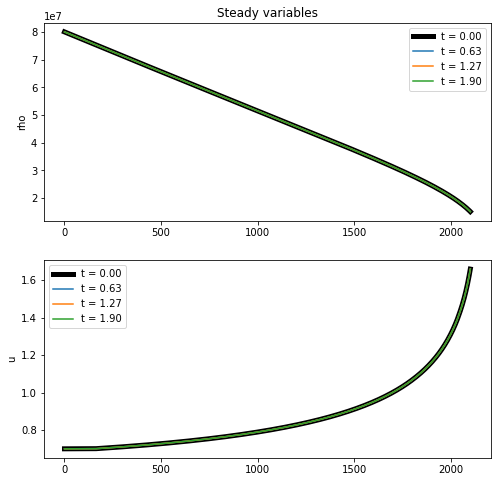

In [50]:
# Steady variable plot

cache_length = 3
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
# Plot steady state pressure
_rho = split_solver._soln_steady.sol(split_solver.x)[0,...]
_yWv = split_solver._soln_steady.sol(split_solver.x)[3,...]
_p = split_solver.p_ptilde(_rho, _yWv)[0]
plt.plot(split_solver.x, _p, 'k', linewidth=5)
# Plot pressures in cache
for cache_idx in range(cache_length):
  plt.plot(split_solver.x, split_solver.cache2[cache_idx][0,:])
  plt.ylabel("rho")
  plt.legend([f"t = {split_solver.dt*i:.2f}" for i in range(cache_length+1)])
plt.title("Steady variables")

plt.subplot(2,1,2)
# Plot velocities
plt.plot(split_solver.x, split_solver._soln_steady.sol(split_solver.x)[1,...], 'k', linewidth=5)
for cache_idx in range(cache_length):
  plt.plot(split_solver.x, split_solver.cache2[cache_idx][1,:])
  plt.ylabel("u")
  plt.legend([f"t = {split_solver.dt*i:.2f}" for i in range(cache_length+1)])

#### Choking flow in subsystem

This section explores the idea of solving the IVP downward from the vent. This turns out of to be unstable because the reaction terms are positive feedback terms that push the relevant variables away from a control set point. The advantage of such an approach is that the choked flow is at the exact location, so that not extrapolation is necessary. However, iteration for the correct vent pressure (minimizing the residual equal to the error in the pressure at the inlet) is still required. An extrapolation of the solution at the chamber turns out to be relatively well-behaved, and should be the more robust method.

c:\Python39\lib\site-packages\scipy\interpolate\_cubic.py:289: RuntimeWarning: overflow encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


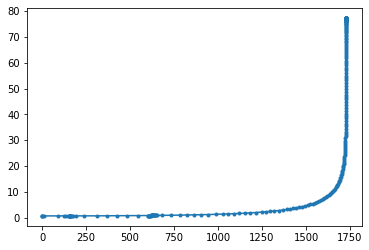

In [654]:

q5_interp_raw = scipy.interpolate.PchipInterpolator(split_solver.x,
                                  split_solver.q5,
                                  extrapolate=True,
                                  axis=1)

def q5_interp(xq):
  ''' Vectorized returns '''
  return np.where(xq <= split_solver.x.max(),
                  q5_interp_raw(xq),
                  split_solver.q5[:,-1:])

def q5_interp_scalar(xq):
  ''' Scalar returns'''
  return np.where(xq <= split_solver.x.max(),
                  q5_interp_raw(xq),
                  split_solver.q5[:,-1])

r_interpolants = q5_interp_scalar
p0=80e6
u0=0.7
xlims:tuple=(0, 5000)
method="Radau"
max_step=np.inf

scales = np.array([1.0, 1.0])
# Create choking event
def event_isothermal_choked(x, q2_scaled) -> np.array:
  ''' Returns isothermal mach squared '''
  p = q2_scaled[0,...] * scales[0]
  u = q2_scaled[1,...] * scales[1]
  yWv = r_interpolants(x)[1,...]
  rho = split_solver.rho_p(yWv, p)
  ptilde = split_solver.p_ptilde(rho, yWv)[1]
  return split_solver.isothermal_mach_squared(u, yWv, p, ptilde) - 1.0
event_isothermal_choked.terminal = True
# event_isothermal_choked.direction = 1.0

# Solve IVP
soln = scipy.integrate.solve_ivp(
  lambda x, q_scaled: split_solver.time_indep_RHS(
    x, q_scaled * scales, r_interpolants, is_debug_mode=False) / scales,
  xlims,
  np.array([p0, u0]) / scales,
  method=method,
  dense_output=True,
  max_step=max_step,
  rtol=1e-6,
  atol=1e-8,
  events=[event_isothermal_choked,])
plt.plot(soln.t, soln.y[1,:], '.-')
# print(soln)


In [140]:
# Solve full steady state IVP in reverse
# Solve IVP in reverse
solubility_k = params["solubility_k"]
solubility_n = params["solubility_n"]

def solve_reverse_full_ivp(p_vent, M_eps=1e-5):
  ''' Warning: this is not using the choked-flow steady state. '''
  # Pick yWt
  yWt_vent = 0.025
  yC_vent = 0.4
  yL_vent = 1.0 - (yWt_vent + yC_vent)
  # yWd_vent = split_solver.yWd_target(yWv, yWt, yC, p)
  yWd_vent = np.clip(solubility_k * p_vent ** solubility_n * yL_vent,
                     0.0, 1.0)
  yWv_vent = yWt_vent - yWd_vent
  yF_vent = 1.0 - yWv_vent - 1e-2
  # Compute vent conditions
  rho_vent = split_solver.rho_p(yWv_vent, p_vent)
  _, ptilde_vent = split_solver.p_ptilde(rho_vent, yWv_vent)
  c_vent = np.sqrt(split_solver.isothermal_sound_speed_squared(
                    yWv_vent, p_vent, ptilde_vent))
  # Compute velocity for Mach at 1 - M_eps
  u_vent = float((1.0 - M_eps) * c_vent)

  assert(split_solver.volfrac_gas(rho_vent, yWv_vent, p_vent)
         > split_solver.vf_g_crit)

  q0 = np.array([p_vent, #rho_vent, ### IMPORTANT
                 float(u_vent),
                 0.0,
                 float(yWv_vent),
                 yWt_vent,
                 yC_vent,
                 float(yF_vent)])

  soln = scipy.integrate.solve_ivp(
    lambda x, q: split_solver.full_steady_state_RHS_p(x, q,
                            is_debug_mode=False),
    (0,2100)[::-1],
    q0,
    method="Radau",
    dense_output=True,
    max_step=.25#max_step,
    # rtol=1e-8,
    # atol=1e-8,
    # events=[event_isothermal_choked,]
    )
  return soln, q0

def solve_full_ivp_L(u0, rtol=1e-5, atol=1e-6):
  ''' Compute full steady state IVP output domain length. '''
  soln = split_solver.solve_full_steady_state(p0=80e6,
                                              u0=u0,
                                              yWt0=0.025,
                                              yC0=0.4,
                                              yF0=0.0,
                                              xlims=(0, 10000),
                                              M_eps=1e-3,
                                              method="BDF",
                                              rtol=rtol, atol=atol)
  return soln, soln.t.max()


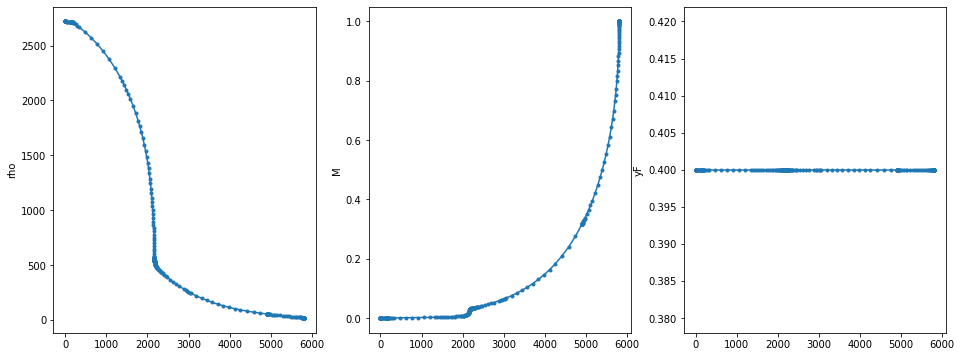

In [141]:
# Full IVP
soln, L = solve_full_ivp_L(0.7)
_p, _ = split_solver.p_ptilde(soln.y[0,:], soln.y[3,:])
_M = split_solver.isothermal_mach_squared_simple(soln.y[1,:], soln.y[3,:], _p)
labels = ["rho", "M", "yF"]
quants = (soln.y[0,:], _M, soln.y[5,:],)
plt.figure(figsize=(16,6))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.plot(soln.t, quants[i], '.-')
  plt.ylabel(labels[i])

In [142]:
# Solve for target conduit length
conduit_length = 2500
u0_solved, results = scipy.optimize.brentq(
  lambda u0: solve_full_ivp_L(u0)[1] - conduit_length,
  0.001, 8.5, full_output=True)

Estimate of L error: 0.5999279244156241


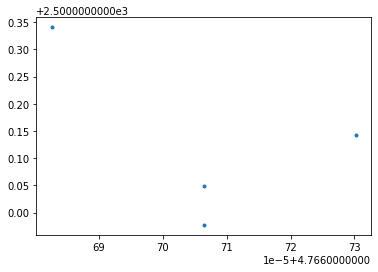

In [185]:
# Estimate uncertainty (derivative dL/du0)

rtol = 1e-5
rtol_highres = 1e-5
atol_highres = 1e-7 * np.array([100, 1.0, 1e3, 1e-1, 1.0, 1.0, 1.0])
# High resolution solves at u0 and u0 +/- epsilon
soln_solved, Lsolved = solve_full_ivp_L(u0_solved)
soln_solved_highres, Lsolved_highres = solve_full_ivp_L(u0_solved, rtol=rtol_highres, atol=atol_highres)
u0_plus = u0_solved * (1 + rtol)
u0_minus = u0_solved * (1 - rtol)
soln_plus_eps, Lplus = solve_full_ivp_L(u0_plus, rtol=rtol_highres, atol=atol_highres)
soln_minus_eps, Lminus = solve_full_ivp_L(u0_minus, rtol=rtol_highres, atol=atol_highres)
# Show estimate
u_ests = u0_solved + np.array([u0_minus, u0_solved, u0_solved, u0_plus])
L_ests = np.array([Lminus, Lsolved, Lsolved_highres, Lplus])
plt.plot(u_ests, L_ests, '.')
# Combine an error estimate from solver resolution and u perturbation
L_error_estimate = np.abs(Lsolved_highres - Lsolved) \
                   + np.abs(Lminus - Lsolved_highres) \
                   + np.abs(Lplus - Lsolved_highres)
print(f"Estimate of L error: {L_error_estimate}")

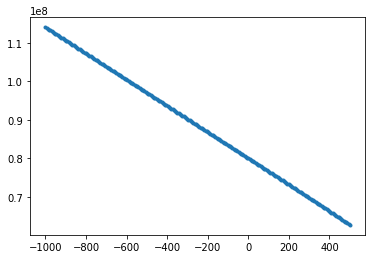

In [181]:
# Solution bottom-extrapolation
soln_solved.t.max()
_t_negative = np.linspace(-1000,500,250)
_q_negative = soln_solved.sol(_t_negative)
_p_negative, _ = split_solver.p_ptilde(_q_negative[0,:], _q_negative[3,:])
plt.plot(_t_negative, _p_negative, '.-')



In [68]:
u_range = np.linspace(0.1, 8.5, 35)
outs = [solve_full_ivp_L(u) for u in u_range]
# L_range = np.array([solve_full_ivp_L(u)[1] for u in u_range])
# plt.plot(u_range, L_range, '.')

Monotonic dependence of L on inlet velocity u_0


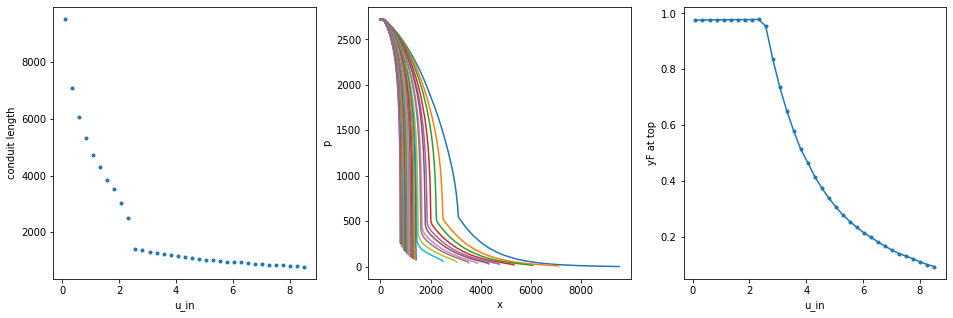

In [77]:
solns, L_range = zip(*outs)
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.plot(u_range, L_range, '.')
plt.xlabel("u_in")
plt.ylabel("conduit length")
plt.subplot(1,3,2)
for i in range(len(solns)):
  plt.plot(solns[i].t, solns[i].y[0,:], '-')
plt.xlabel("x")
plt.ylabel("p")
plt.subplot(1,3,3)
yF_top = [soln.y[-1,-1] for soln in solns]
plt.plot(u_range, yF_top, '.-')
plt.xlabel("u_in")
plt.ylabel("yF at top")

print("Monotonic dependence of L on inlet velocity u_0")

In [760]:
_soln, _q0 = solve_reverse_full_ivp(3e5)
_q0
-split_solver.full_steady_state_RHS(None, _q0)

rho = _q0[0,]
yWv = _q0[3,]
yWt = _q0[4,]
yC = _q0[5,]
yWd = yWt - yWv
p, ptilde = split_solver.p_ptilde(rho, yWv)
split_solver.yWd_target(yWv, yWt, yC, p)
split_solver.full_steady_state_RHS(None, _q0), (yWd - split_solver.yWd_target(yWv, yWt, yC, p)) / (split_solver.tau_d), _q0
# split_solver.volfrac_gas(rho, yWv, p)

c:\Users\Fredric\OneDrive\Documents\lowM_split.py:83: RuntimeWarning: invalid value encountered in double_scalars
  return np.clip(self.solubility_k * p ** self.solubility_n * yL, 0, yWt)


(array([-2.94393294e+07,  1.51612867e+08,  0.00000000e+00, -2.24472958e-21,
         0.00000000e+00,  0.00000000e+00,  3.45066267e-04]),
 -2.6020852139652105e-19,
 array([2.25086442e+01, 1.15919763e+02, 0.00000000e+00, 2.34252976e-02,
        2.50000000e-02, 4.00000000e-01, 9.66574702e-01]))

In [801]:
p_test = np.linspace(1e5, 20e5, 3)
solns = [solve_reverse_full_ivp(p) for p in p_test]

c:\Users\Fredric\OneDrive\Documents\lowM_split.py:83: RuntimeWarning: invalid value encountered in sqrt
  return np.clip(self.solubility_k * p ** self.solubility_n * yL, 0, yWt)


In [794]:
[soln[0].message for soln in solns]

['Required step size is less than spacing between numbers.',
 'Required step size is less than spacing between numbers.',
 'Required step size is less than spacing between numbers.']

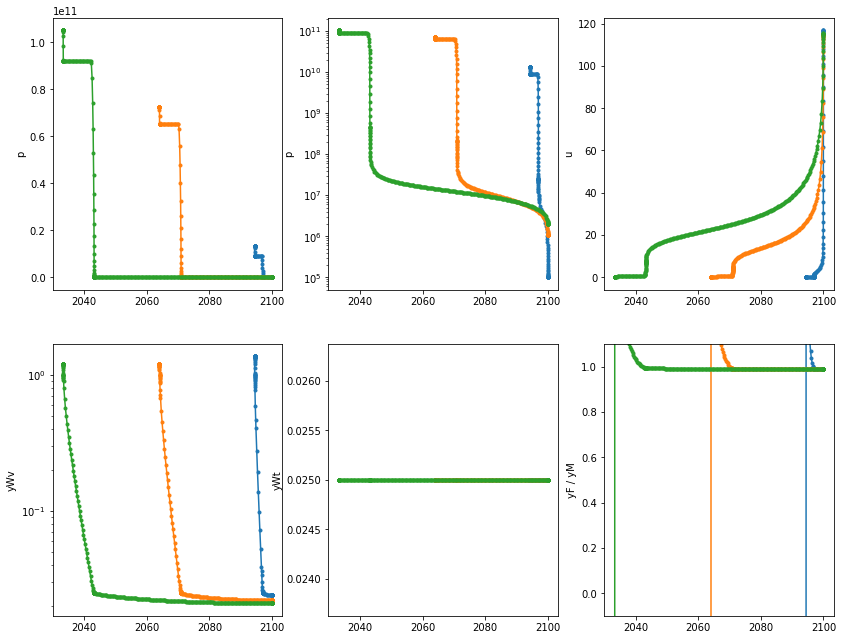

In [802]:
plt.figure(figsize=(14,11))
for i, (soln, q0) in enumerate(solns):
  plt.subplot(2,3,1)
  plt.plot(soln.t, soln.y[0,:], '.-')
  plt.ylabel("p")
  plt.subplot(2,3,2)
  plt.semilogy(soln.t, soln.y[0,:], '.-')
  plt.ylabel("p")
  plt.subplot(2,3,3)
  plt.plot(soln.t, soln.y[1,:], '.-')
  plt.ylabel("u")

  plt.subplot(2,3,4)
  plt.semilogy(soln.t, soln.y[3,:], '.-')
  plt.ylabel("yWv")
  plt.subplot(2,3,5)
  plt.plot(soln.t, soln.y[4,:], '.-')
  plt.ylabel("yWt")
  plt.subplot(2,3,6)
  plt.plot(soln.t, soln.y[6,:] / (1 - soln.y[3,:]), '.-')
  plt.ylabel("yF / yM")
  plt.ylim(-.1,1.1)

In [704]:
# Solve IVP in reverse
def solve_reverse_ivp(p_vent, M_eps=1e-5):
  ''' Warning: this is not using the choked-flow steady state. '''
  # Compute vent conditions from q5
  yWv_vent = split_solver.q5_interp([2100])[1,:]
  # yWv_vent = split_solver._soln_steady.y[3,-1]
  rho_vent = split_solver.rho_p(yWv_vent, p_vent)
  _, ptilde_vent = split_solver.p_ptilde(rho_vent, yWv_vent)
  c_vent = np.sqrt(split_solver.isothermal_sound_speed_squared(
                    yWv_vent, p_vent, ptilde_vent))
  # Compute velocity for Mach at 1 - M_eps
  u_vent = float((1.0 - M_eps) * c_vent)

  print(u_vent)

  q5_interp_raw = scipy.interpolate.PchipInterpolator(split_solver.x,
                                  split_solver.q5,
                                  extrapolate=True,
                                  axis=1)
  def q5_interp(xq):
    ''' Vectorized returns '''
    return np.where(xq <= split_solver.x.max(),
                    q5_interp_raw(xq),
                    split_solver.q5[:,-1:])

  def q5_interp_scalar(xq):
    ''' Scalar returns'''
    return np.where(xq <= split_solver.x.max(),
                    q5_interp_raw(xq),
                    split_solver.q5[:,-1])

  soln = scipy.integrate.solve_ivp(
    lambda x, q_scaled: split_solver.time_indep_RHS(
      x, q_scaled * scales, r_interpolants, is_debug_mode=False) / scales,
    (0,2100)[::-1],
    np.array([p_vent, u_vent]) / scales,
    method=method,
    dense_output=True,
    max_step=max_step,
    rtol=1e-4,
    # atol=1e-8,
    # events=[event_isothermal_choked,]
    )
  return soln

plt.figure(figsize=(14,6))
p_test = np.linspace(1e5, 20e5, 81)
for p in p_test:
  soln = solve_reverse_ivp(p)
  plt.subplot(1,3,1)
  plt.plot(soln.t, soln.y[0,:], '.-')
  plt.ylabel("p")
  plt.subplot(1,3,2)
  plt.semilogy(soln.t, soln.y[0,:], '.-')
  plt.ylabel("p")
  plt.subplot(1,3,3)
  plt.plot(soln.t, soln.y[1,:], '.-')
  plt.ylabel("u")


78.66057230214389


c:\Python39\lib\site-packages\scipy\interpolate\_cubic.py:289: RuntimeWarning: overflow encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
c:\Users\Fredric\OneDrive\Documents\lowM_split.py:83: RuntimeWarning: invalid value encountered in sqrt
  return np.clip(self.solubility_k * p ** self.solubility_n * yL, 0, yWt)


ValueError: array must not contain infs or NaNs

<Figure size 1008x432 with 0 Axes>

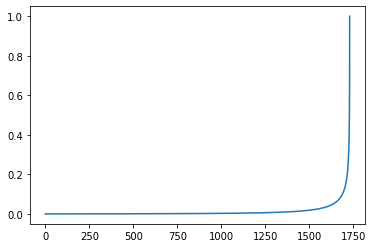

In [653]:
def q2_to_stats(x, q2_interp, q5_interp):
  p, u = q2_interp(x)
  _, yWv, yWt, yC, yF = q5_interp(x)
  rho = split_solver.rho_p(yWv, p)
  _, ptilde = split_solver.p_ptilde(rho, yWv)
  M = np.sqrt(split_solver.isothermal_mach_squared(u, yWv, p, ptilde))
  return {
    "p": p,
    "u": u,
    "yWv": yWv,
    "yWt": yWt,
    "yC": yC,
    "yF": yF,
    "rho": rho,
    "ptilde": ptilde,
    "cT": u / M,
    "M": M,
    "x": x,
  }

out_vals = q2_to_stats(soln.t, soln.sol, q5_interp)
plt.plot( out_vals["x"], out_vals["M"] )

## Library version of choked low-Mach flow

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import scipy
import scipy.interpolate
import matplotlib.pyplot as plt

locale = r"C:\Users\Fredric\Documents\Volcano\quail_volcano\src\compressible_conduit_steady"
import os
os.chdir(locale)
import steady_state

x_km_range = np.linspace(0, 15000, 100)
f = steady_state.SteadyState(x_km_range, 1e5, 100e6, input_type="p",
                             override_properties={
                               "tau_f": 1e0, # 1e-2,
                               "tau_d": 1e0, # 1e-2,
                              #  "yWt": 0.05,
                               "yC": 0.4,
                               "rho0_magma": 2.6e3,
                             }, skip_rootfinding=True)

In [3]:
from scipy.special import erf
def loc_F_fric_viscosity_model(T, y, yF, yWt=0.03, yC=0.4):
    ''' Calculates the viscosity as a function of dissolved
    water and crystal content (assumes crystal phase is incompressible)/
    Does not take into account fragmented vs. not fragmented (avoiding
    double-dipping the effect of fragmentation).
    '''
    # Calculate pure melt viscosity (Hess & Dingwell 1996)
    yWd = yWt - y
    yM = 1.0 - y
    yL = yM - (yWd + yC)
    mfWd = yWd / yL # mass concentration of dissolved water
    mfWd = np.where(mfWd <= 0.0, 1e-8, mfWd)
    log_mfWd = np.log(mfWd*100)
    log10_vis = -3.545 + 0.833 * log_mfWd
    log10_vis += (9601 - 2368 * log_mfWd) / (T - 195.7 - 32.25 * log_mfWd)
    # Prevent overflowing float
    log10_vis = np.where(log10_vis > 300, 300, log10_vis)
    meltVisc = 10**log10_vis
    # Calculate relative viscosity due to crystals (Costa 2005).
    alpha = 0.999916
    phi_cr = 0.673
    gamma = 3.98937
    delta = 16.9386
    B = 2.5
    # Compute volume fraction of crystal at equal phasic densities
    # Using crystal volume per (melt + crystal + dissolved water) volume
    phi_ratio = np.clip((yC / yM) / phi_cr, 0.0, None)
    erf_term = erf(
      np.sqrt(np.pi) / (2 * alpha) * phi_ratio * (1 + phi_ratio**gamma))
    crysVisc = (1 + phi_ratio**delta) * ((1 - alpha * erf_term)**(-B * phi_cr))
    
    viscosity = meltVisc * crysVisc
    return viscosity

In [5]:
import lowM_split
import importlib
importlib.reload(lowM_split)

params = {
  "T0": 950+273.15,
  "conduit_radius": 10,
  "tau_d": 5., # CHECK, and Euler stability; next: most likely need BVP with p BCs instead of this
  "tau_f": .25, # TODO: add resonant case for tau_f == tau_d
  "vf_g_crit": 0.8,
  "solubility_n": f.solubility_n,
  "solubility_k": f.solubility_k,
  "K": 10e9,
  "rho_m0": 2.7e3,
  "p_m0": 5e6,
  "R_wv": f.mixture.waterEx.R,
  "F_fric_viscosity_model": loc_F_fric_viscosity_model,
}

# Remember: Nx needs enough resolution of the front as well
split_solver = lowM_split.SplitSolver(params, Nt=100)
q2, q5 = split_solver.full_solve_choked((0,2100), Nx=2001, p0=80e6, u0=0.4, yWt0=0.025,
                 yC0=0.4, yF0=0.0, CFL=100)
print(f"Final t: {split_solver.t} s")

DEBUG:lowM_split_2023-09-29T144324:Steady state brentq called.
DEBUG:lowM_split_2023-09-29T144324:Steady state brentq call results:       converged: True
           flag: 'converged'
 function_calls: 38
     iterations: 37
           root: 2.489977950745467
DEBUG:lowM_split_2023-09-29T144324:Steady state solve called with u0 = 2.489977950745467
DEBUG:lowM_split_2023-09-29T144324:Timestep loop entered with with dt = 0.9490853430474822.
DEBUG:lowM_split_2023-09-29T144324:Setup time was 9.339704700003495.
DEBUG:lowM_split_2023-09-29T144324:q5 L2-norm:                    [ 0.          0.54574118  1.14564392 18.33030278 25.16093457]
DEBUG:lowM_split_2023-09-29T144324:q5 L2-norm advected:           [ 0.          0.53541839  1.14564392 18.33041953 24.79601313]
DEBUG:lowM_split_2023-09-29T144324:q5 L2-norm advected + reacted: [ 0.          0.54637857  1.14564392 18.33041953 25.14204777]
DEBUG:lowM_split_2023-09-29T144324:Clip stage: is q5 == np.clip: False
DEBUG:lowM_split_2023-09-29T144324:Sk

KeyboardInterrupt: 

In [40]:
rho_vent

2698.92

In [74]:
split_solver.q5_interp(np.array([0,])).shape

(5, 1)

In [87]:
split_solver

def p_chamber_x_chamber(p_vent):
  q5_interp_scalar = lambda x: split_solver.q5_interp(np.array([float(x),]))[:,0]
  xlims = (0, 2100)
  yWv_vent = q5_interp_scalar(xlims[-1])[1]
  # yWv_vent = split_solver._soln_steady.y[3,-1]
  rho_vent = split_solver.rho_p(yWv_vent, p_vent)
  _, ptilde_vent = split_solver.p_ptilde(rho_vent, yWv_vent)
  c_vent = np.sqrt(split_solver.isothermal_sound_speed_squared(
                    yWv_vent, p_vent, ptilde_vent))
  # Compute velocity for Mach at 1 - M_eps
  M_eps = 1e-2
  u_vent = float((1.0 - M_eps) * c_vent)
  soln = scipy.integrate.solve_ivp(
            lambda x, q: split_solver.time_indep_RHS(
              x, q, q5_interp_scalar, is_debug_mode=False),
            xlims[::-1],
            np.array([p_vent, u_vent]),
            method="Radau",
            dense_output=True,
            # max_step=max_step,
            rtol=1e-3,
            # atol=1e-8,
            )
  return soln.y[0,-1], soln.t.min()

In [94]:
p_vent_range = np.geomspace(1e4, 1e6, 210)
_outs = [p_chamber_x_chamber(p) for p in p_vent_range]
p_chamber, x_chamber = zip(*_outs)

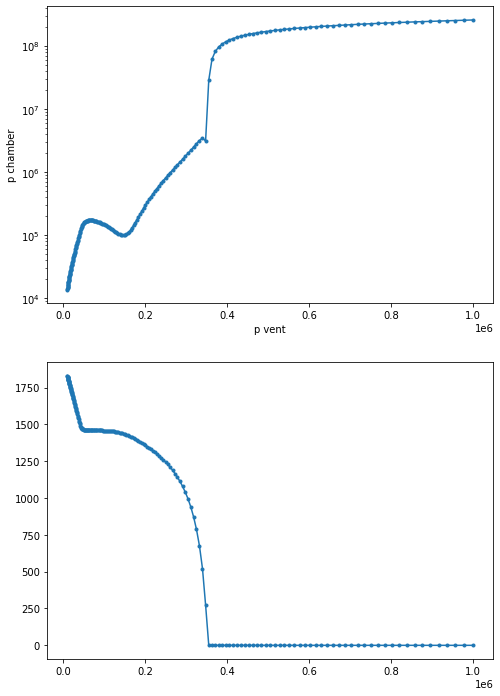

In [98]:
plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
plt.semilogy(p_vent_range, p_chamber, '.-')
plt.xlabel("p vent")
plt.ylabel("p chamber")
plt.subplot(2,1,2)
plt.plot(p_vent_range, x_chamber, '.-')

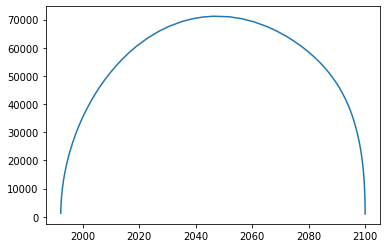

In [79]:
plt.plot(soln.t, soln.y[0,:])


In [61]:
soln = scipy.integrate.solve_ivp(
  lambda x, q: split_solver.time_indep_RHS(
    x, q, q5_interp_scalar, is_debug_mode=False),
  xlims[::+1],
  np.array([80e6, split_solver.u0]),
  method="Radau",
  dense_output=True,
  # max_step=max_step,
  rtol=1e-5,
  # atol=1e-8,
  )

In [67]:
q5_interp_scalar(3)

array([0., 0., 0., 0., 0.])

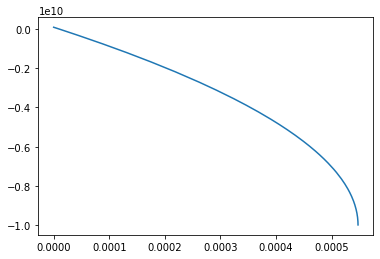

In [62]:
plt.plot(soln.t, soln.y[0,:])


The solver successfully reached the end of the integration interval.


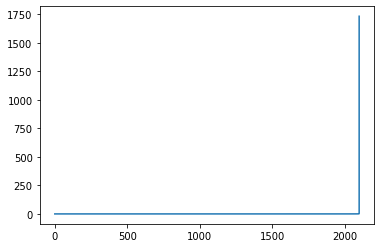

In [52]:
print(soln.message)
plt.plot(soln.t, soln.y[1,:])


In [20]:
import timeit
t_clock = timeit.timeit(lambda: split_solver.time_indep_RHS(split_solver.x[0],
                                          split_solver.q2[:,0],
                                          lambda x:split_solver.q5_interp(x)[:,0]), number=10000)/10000*1e3
f"{t_clock} ms"

'0.17801804000046104 ms'

In [ ]:
def time_indep_RHS(self, x, q2:np.array, r_interpolants:callable,
                     is_debug_mode=False):
    ''' RHS for time-independent portion of the system.
    Inputs:
      x -- independent coordinate
      q2 -- state vector of size 2 (p, u)
      r_interpolants -- interpolation for slow-time-dependent variables
      is_debug_mode (optional) -- flag for returning debug quantities
    '''    
    # Interpolate solution for time-dependent quantities
    r = r_interpolants(x)
    # Unpack quantities
    p         = q2[0,...]
    u         = q2[1,...]
    yWv       = r[1,...]
    yWt       = r[2,...]
    yC        = r[3,...]
    yF        = r[4,...]
    # Extract spatial derivative of rho prime
    # dyw_dt        = dyw_dt_interpolant(t)
    '''Compute aliases'''
    yM = 1.0 - yWv
    yWd = yWt - yWv

    '''Compute EOS quantities'''
    v = yWv * self.vWv_p(p) + yM * self.vM_p(p)
    rho = 1.0 / v
    _, ptilde = self.p_ptilde(rho, yWv)
    # Compute mixture isothermal sound speed, squared
    cT2 = self.isothermal_sound_speed_squared(yWv, p, ptilde)
    # Compute partial of pressure w.r.t. water mass fraction (const rho, T)
    dp_dyw = self.dp_dyw(rho, p, ptilde)

    # Compute solubility based on pure silicate melt mass fraction
    yHat = self.yWd_target(yWv, yWt, yC, p)
    # Compute sources
    source_yWv = (yWd - yHat) / (self.tau_d)

    # Compute momentum load
    mu = self.F_fric_viscosity_model(self.T0, yWv, yF, yWt=yWt, yC=yC)
    F_fric = 8.0 * mu / (self.conduit_radius * self.conduit_radius) * u \
      * np.clip(1.0 - yF/yM, 0.0, 1.0)
    source_momentum = (-rho * 9.8 - F_fric) / rho
    # Compute explicitly inverted LHS matrix
    #   for state vector [rho_bar, u]
    Ainv = np.array([[u, -rho*cT2], [-v, u]]) / (u*u - cT2)
    # Compute RHS vector
    b = np.stack([dp_dyw * source_yWv,
                  + source_momentum,
                  ], axis=0)
    
    return np.array([Ainv[0,0] * b[0] + Ainv[0,1] * b[1],
                     Ainv[1,0] * b[0] + Ainv[1,1] * b[1]])

In [280]:
os.getcwd()

'C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\compressible_conduit_steady'

0.999949998749417

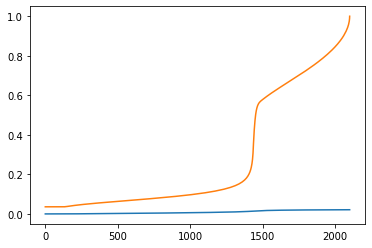

In [284]:
plt.plot(split_solver.soln_steady_solved.t,
         split_solver.soln_steady_solved.y[3,:])

rho = split_solver.soln_steady_solved.y[0,:]
u = split_solver.soln_steady_solved.y[1,:]
yWv = split_solver.soln_steady_solved.y[3,:]
p, ptilde = split_solver.p_ptilde(rho, yWv)

M = np.sqrt(split_solver.isothermal_mach_squared_simple(u, yWv, p))
plt.plot(split_solver.soln_steady_solved.t, M)
M[-1]

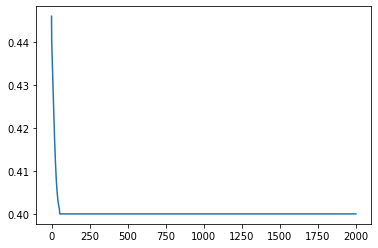

In [285]:
plt.plot(split_solver.out_q5[-1,3,:])

(2, 2001)

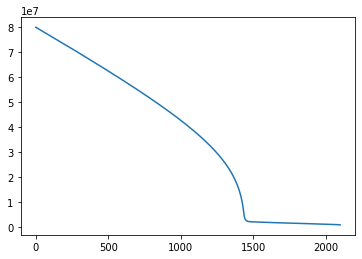

In [251]:
_q_steady = split_solver.steady_interp(split_solver.x)
plt.plot(split_solver.x, q2[0,:])
_q_steady.shape

In [156]:
out_q2 = np.load(r"C:\Users\Fredric\Desktop\run2\out_q2_new.npy")
out_q5 = np.load(r"C:\Users\Fredric\Desktop\run2\out_q5_new.npy")
x = np.load(r"C:\Users\Fredric\Desktop\run2\out_x_new.npy")
t = np.load(r"C:\Users\Fredric\Desktop\run2\out_t_new.npy")
mg_x, mg_t = np.meshgrid(x, t)

In [154]:
''' Information not recorded? Manually import here: '''
# split_solver.x.shape
# split_solver.dt
# x = np.linspace(0,2100,1001)
# dt = 0.9490853430474822
# t = dt * (np.arange(300+1))
# mg_x, mg_t = np.meshgrid(x, t)

' Information not recorded? Manually import here: '

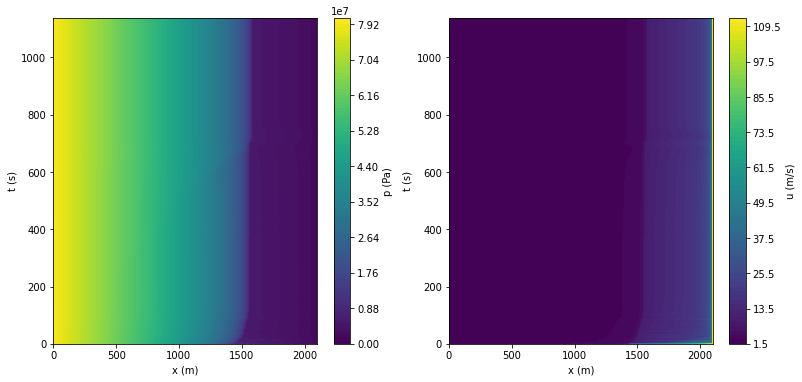

In [160]:
# Pressure contouring
p = out_q2[:,0,:]
u = out_q2[:,1,:]
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
plt.contourf(mg_x, mg_t, p, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.colorbar(label="p (Pa)")
plt.subplot(1,2,2)
plt.contourf(mg_x, mg_t, u, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.colorbar(label="u (m/s)")

In [146]:
yC.max()

0.4499800116007677

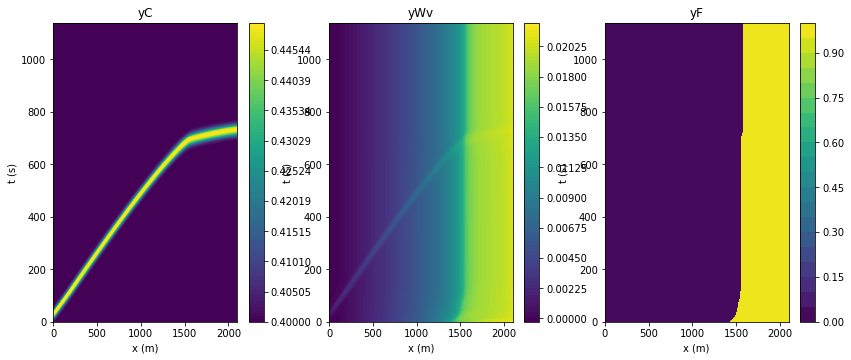

In [164]:
# Pressure contouring
yWv = out_q5[:,1,:]
yC = out_q5[:,3,:]
yF = out_q5[:,4,:]
plt.figure(figsize=(14,5.5))
plt.subplot(1,3,1)
yC_range = (yC.min(), yC.max())
plt.contourf(mg_x, mg_t, yC, levels=np.linspace(*yC_range, 100))
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.colorbar()
plt.title("yC")
plt.subplot(1,3,2)
plt.contourf(mg_x, mg_t, yWv, levels=100)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("yWv")
plt.colorbar()
plt.subplot(1,3,3)
plt.contourf(mg_x, mg_t, yF, levels=20)
plt.xlabel("x (m)")
plt.ylabel("t (s)")
plt.title("yF")
plt.colorbar()

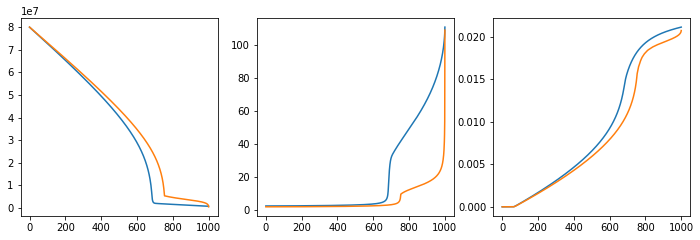

In [168]:
# Check t = 0 and t = tf: are these two viable steady-states?
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.plot(out_q2[0,0,:])
plt.plot(out_q2[-1,0,:])
plt.subplot(2,3,2)
plt.plot(out_q2[0,1,:])
plt.plot(out_q2[-1,1,:])
plt.subplot(2,3,3)
plt.plot(out_q5[0,1,:])
plt.plot(out_q5[-1,1,:])
plt.subplot(2,3,4)
plt.plot(out_q5[0,2,:])
plt.plot(out_q5[-1,2,:])


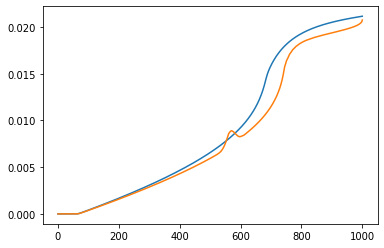

In [111]:
plt.plot(out_q5[0,1,:])
plt.plot(out_q5[-1,1,:])
